# start

In [1]:
a=2
a-1


1

In [258]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import random
np.random.seed(42)

def parse_tree_file(tree_df,children,parents):
    # create a dictionary from taxonomic id to index of corresponding row
    info = {}
    for i in range(len(children)):
        info[int(children[i])] = int(i)

    # Convert to tree structure (dictionary of sets)
    Tree = {}
    for i in range(len(tree_df[0])):
        parent = int(parents[i])
        child = int(children[i])
        if parent in Tree:
            Tree[parent].add(child)
        else:
            Tree[parent] = {child}
    return info, Tree 
    
def find_tax_level(info,tree_df,parents, tid, tax_level="species"):
    if tid not in info:
        #print(tid)
        return -1
    while tid != 1:    
        tid_row = info[tid]
        if tree_df[4][tid_row] == tax_level:
            break
        else:
            tid = parents[info[tid]] #find_parent_node(tid)
            # if retrun 1, it means that the tid is more towaards root that the requested level
    return tid


# def read_kraken(file):

#     # "C"/"U": a one letter code indicating that the sequence was either classified or unclassified.
#     # The sequence ID, obtained from the FASTA/FASTQ header.
#     # The taxonomy ID Kraken 2 used to label the sequence; this is 0 if the sequence is unclassified.
#     # The length of the sequence in bp. In the case of paired read data, this will be a string containing the lengths of the two sequences in bp, separated by a pipe character, e.g. "98|94".
#     # A space-delimited list indicating the LCA mapping of each  k-mer in the sequence(s).
#     # For example, "562:13 561:4 A:31 0:1 562:3" would indicate that:
#     # the first 13 k-mers mapped to taxonomy ID #562 ... 31  ambiguous nucleotide (A)
#     file_o=open(file,'r')
#     dic_krak={}
#     lines=0
#     for line in file_o:
#         line_split=line.strip().split("\t")
#         if line_split[0]=="C":
#             read_id, tax_krak, read_len, tax_kmers = line_split[1:]
#             tax_kmer_num_dic={}
#             tax_kmer_dic={}
#             pos=-1
#             for tax_kmer in tax_kmers.split(" "):
                
#                 tax, num_raw =  tax_kmer.split(":")
#                 num=int(num_raw)
#                 pos+=num # how many consecutive kmer has this taxid # 0:6 543:1 91347:1 six unclassified, 
#                 if tax==0 or tax =='A':
#                     continue
#                 #tax=int(tax_)
#                 if int(tax) in tax_kmer_dic:
#                     tax_kmer_dic[int(tax)].append( (pos,num))
#                     tax_kmer_num_dic[int(tax)]+=num
#                 else:    
#                     tax_kmer_dic[int(tax)]=[(pos,num)]
#                     tax_kmer_num_dic[int(tax)]=num
#             dic_krak[read_id] = int(tax_krak), int(read_len), tax_kmer_dic
#     return dic_krak



def read_kraken_set(file,read_names):

    # "C"/"U": a one letter code indicating that the sequence was either classified or unclassified.
    # The sequence ID, obtained from the FASTA/FASTQ header.
    # The taxonomy ID Kraken 2 used to label the sequence; this is 0 if the sequence is unclassified.
    # The length of the sequence in bp. In the case of paired read data, this will be a string containing the lengths of the two sequences in bp, separated by a pipe character, e.g. "98|94".
    # A space-delimited list indicating the LCA mapping of each  k-mer in the sequence(s).
    # For example, "562:13 561:4 A:31 0:1 562:3" would indicate that:
    # the first 13 k-mers mapped to taxonomy ID #562 ... 31  ambiguous nucleotide (A)
    file_o=open(file,'r')
    dic_krak={}
    for line in file_o:
        line_split=line.strip().split("\t")
        if line_split[0]=="C":
            read_id, tax_krak, read_len, tax_kmers = line_split[1:]
            if read_id in read_names:
                tax_kmer_dic={}
                tax_kmer_num_dic={}
                pos=-1
                for tax_kmer in tax_kmers.split(" "):
                    
                    tax_, num_raw =  tax_kmer.split(":")
                    
                    num=int(num_raw)
                    pos+=num     # how many consecutive kmer has this taxid # 0:6 543:1 91347:1 six unclassified, 
                    if tax_=='0' or tax_ =='A':
                        continue

                    tax=int(tax_)
                    if tax in tax_kmer_dic:
                        tax_kmer_dic[tax].append( (pos,num))
                        tax_kmer_num_dic[tax]+=num
                    else:    
                        tax_kmer_dic[tax]=[(pos,num)]
                        tax_kmer_num_dic[tax]=num
                dic_krak[read_id] = int(tax_krak), int(read_len), tax_kmer_dic, tax_kmer_num_dic
    return dic_krak



def read_kraken_limited(file,numer_rows=1000):
    file_o=open(file,'r')
    dic_krak={}
    lines=0
    for line in file_o:
        lines+=1
        if lines<numer_rows:
            line_split=line.strip().split("\t")
            if line_split[0]=="C":
                read_id, tax_krak, read_len, tax_kmers = line_split[1:]

                tax_kmer_num_dic={}
                tax_kmer_dic={}
                pos=-1
                for tax_kmer in tax_kmers.split(" "):
                    
                    tax_, num_raw =  tax_kmer.split(":")
                    
                    num=int(num_raw)
                    pos+=num     # how many consecutive kmer has this taxid # 0:6 543:1 91347:1 six unclassified, 
                    if tax_=='0' or tax_ =='A':
                        continue

                    tax=int(tax_)
                    if tax in tax_kmer_dic:
                        tax_kmer_dic[tax].append( (pos,num))
                        tax_kmer_num_dic[tax]+=num
                    else:    
                        tax_kmer_dic[tax]=[(pos,num)]
                        tax_kmer_num_dic[tax]=num

                dic_krak[read_id] = int(tax_krak), int(read_len), tax_kmer_dic, tax_kmer_num_dic
    return dic_krak

def find_tax2root(info,parents, tid):
    if tid not in info:
        #print(tid)
        return -1
    list_tax2root=[]
    while tid != 1:    
        list_tax2root.append(tid)
        tid = int(parents[info[tid]])
    list_tax2root.append(tid)
    return list_tax2root



def lca_finder_list(info,parents, tax_list):
    lca=tax_list[0]
    
    for tax2 in tax_list[1:]:
        lca = lca_finder(info,parents, lca,tax2)
        
    return lca

def lca_finder(info,parents, tax1,tax2):
    list_tax2root_1 = find_tax2root(info,parents, tax1)
    list_tax2root_2 = find_tax2root(info,parents, tax2)
    
    list_tax2root1 =list_tax2root_1 [::-1] # reverse from root to leaf
    list_tax2root2 =list_tax2root_2 [::-1]
    
    depth_i = 0
    while(depth_i < len(list_tax2root1) and depth_i < len(list_tax2root2)):
        #print(depth_i)
        if list_tax2root1[depth_i] != list_tax2root2[depth_i]:
            break
        depth_i += 1
    assert list_tax2root1[depth_i-1] == list_tax2root2[depth_i-1], "issue in LCA finding"
    lca=list_tax2root1[depth_i-1]
    #print(lca)
    return lca

    
def first_nonzero(lst):
    for num in lst:
        if num != 0:
            return num
    return None  # In case all elements are zero


def first_nonzero_idx(lst):
    for idx, num in enumerate(lst):
        if num != 0:
            return idx
    return None  # In case all elements are zero    


def find_tax_best_path(tax_krak, read_len, tax_kmer_dic,dic_tax_indx ):
    
    tax2root_paths_num=[]
    for tax2root_idx_l in tax2root_all:
        tax2root_paths_num.append(np.zeros(len(tax2root_idx_l)))
    
    for tax, num in tax_kmer_dic.items():
        if tax==0:
            continue

        tax2root_idx_list = dic_tax_indx[tax]
        for tax2root_idx in tax2root_idx_list:
            tax2root_idx_idx = tax2root_all[tax2root_idx].index(tax)
            tax2root_paths_num[tax2root_idx][tax2root_idx_idx]+=num

    tax2root_paths_sum = [np.sum(tax2root_path) for idx, tax2root_path in enumerate(tax2root_paths_num)]
    #tax2root_paths_sum = [np.dot(tax2root_path,[1.25**i for i in reversed(range(len(tax2root_path)))] ) for idx, tax2root_path in enumerate(tax2root_paths_num)]

    tax_best_path = tax2root_all[np.argmax(tax2root_paths_sum)]
    tax2root_path_num =  tax2root_paths_num[np.argmax(tax2root_paths_sum)]

    # if score are the same, kraken get the LCA of two 

    first_idx = first_nonzero_idx(tax2root_path_num)
    
    tax_found = tax_best_path[first_idx]

    # debugging 
    # for idx, tax2root_path in enumerate(tax2root_paths_num):
    #     if np.sum(tax2root_path) >1050: 
    #         print(tax2root_path,tax2root_all[idx])
    #         #print(np.dot(tax2root_path,[ 1.25**i for i in reversed(range(len(tax2root_path)))]))
    #         print(np.sum(tax2root_path))
    #         print(len(tax2root_path),"\n")
    #         #tax2root_paths_sum = [ ) for idx, tax2root_path in enumerate(tax2root_paths_num)]
                    
    
    return tax_found


import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt


def def_cal(dfmerged_taxa,info,tree_df,parents,tax_level,col_name,tax_index):

    #print(tax_level)
    cases_dic={"TP":set(),"FP-level-notindex":set(), 'FP-higher-notindex':set(),"FP-level-index":set(), 'FP-higher-index':set(),
               'inconsistent-tool':set(), 'TN':set(),
               'FN':set(),'VP':set(), "truth-level":set(), "no-truth-level":set(),"total_unclassified":set()} #  at the level ,'taxNotfoundintool':[]
    num_reads=len(dfmerged_taxa["taxon"])
    for j in range(num_reads):
        #if j%200000==0: print("working at row",j," out of",num_reads, "total reads")
        
        tid_true = dfmerged_taxa["taxon"][j]
        tid_tool = dfmerged_taxa[col_name][j]
        if tid_tool==1:
            tid_tool=2
        
        tid_true_taxlevel = find_tax_level(info,tree_df,parents, tid_true, tax_level)
        tid_tool_taxlevel = find_tax_level(info,tree_df,parents, tid_tool, tax_level)
    
        if tid_tool_taxlevel==-1 and tid_tool!=0:
            cases_dic['inconsistent-tool'].add(dfmerged_taxa['read_name'][j])
            # tid_tool_taxlevel==-1 we are ignoring these reads if the tax is not in the node.dump 
            # we think these cases are limited and probably happened due to different node.dump in build vs evaluation 
    
        
        if tid_tool==0 :
            cases_dic["total_unclassified"].add(dfmerged_taxa['read_name'][j])
        if tid_tool==-1 or tid_true < 1:
            print("to check ",j,tid_tool, tid_true, tid_true_taxlevel)

            #to check  9400 632 0 -1
    
        if tid_true_taxlevel ==1 or  tid_true_taxlevel==-1 or (tid_tool_taxlevel==-1 and tid_tool!=0): # true is not at the level, is higher than the level     or true doest not exist in info
            #including 'inconsistent-tool'
            cases_dic["no-truth-level"].add(dfmerged_taxa['read_name'][j])
            
        else:
            cases_dic["truth-level"].add(dfmerged_taxa['read_name'][j])
    
        if tid_true_taxlevel >1 and tid_tool==0:
            if tid_true in tax_index:
                cases_dic['FN'].add(dfmerged_taxa['read_name'][j]) # unclassified, among reads with true label at the level 
            else:
                cases_dic['TN'].add(dfmerged_taxa['read_name'][j]) # unclassified, among reads with true label at the level 
            
        if tid_true_taxlevel>1 and tid_tool_taxlevel==tid_true_taxlevel :
            cases_dic['TP'].add(dfmerged_taxa['read_name'][j]) # correct
    
        if tid_true_taxlevel>1 and tid_tool>1 and tid_tool_taxlevel==1 :  # tool labled at higher than taxlevel 
            tool_level= tree_df[4][info[tid_tool]]
            tid_true_toollevel = find_tax_level(info,tree_df,parents, tid_true, tool_level)
            if tid_true_toollevel == tid_tool: # at the tool level is correct 
                cases_dic['VP'].add(dfmerged_taxa['read_name'][j]) # vague positive, one deeper lvel (ancestror)  match    
            if tid_true_toollevel != tid_tool:
                if tid_true in tax_index:
                    cases_dic['FP-higher-index'].add(dfmerged_taxa['read_name'][j]) # tool labeld at higher level and worng (not a VP) 
                else:
                    cases_dic['FP-higher-notindex'].add(dfmerged_taxa['read_name'][j]) # tool labeld at higher level and worng (not a VP) 
    
        if tid_true_taxlevel > 1 and tid_tool_taxlevel>1 and  tid_tool_taxlevel != tid_true_taxlevel :
            if tid_true in tax_index:
                cases_dic['FP-level-index'].add(dfmerged_taxa['read_name'][j]) # tool labeled at the tax level (or lower) and wrong 
            else:
                cases_dic['FP-level-notindex'].add(dfmerged_taxa['read_name'][j]) # tool labeled at the tax level (or lower) and wrong             
               
    return cases_dic


def find_root2leaf_path(tax2root_all,threshold_score_perkmer=1,threshold_score_perpath=1): # parse and find the leaf-root path  for each dic of kmers tax 
    
    tax2root_paths_num=[]
    for tax2root_idx_l in tax2root_all:
        tax2root_paths_num.append(np.zeros(len(tax2root_idx_l)))
    
    for tax, pos_num in tax_kmer_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
        if tax==0:
            continue
    
        num = sum([i[1] for i in pos_num])
    
        tax2root_idx_list = dic_tax_indx[tax]
        for tax2root_idx in tax2root_idx_list:
            tax2root_idx_idx = tax2root_all[tax2root_idx].index(tax)
            tax2root_paths_num[tax2root_idx][tax2root_idx_idx]+=num
    
    tax2root_paths_filt = []
    tax2root_paths_num_filt = []
    for idx  in range(len(tax2root_all)):
        tax2root_path= tax2root_all[idx]
        tax2root_num= tax2root_paths_num[idx]
       
        if np.sum(tax2root_num) >= threshold_score_perpath: 
            print(tax2root_num)
            tax2root_num_idx2=[]
            tax2root_path2=[]
            first_nonzero=False
            for ii in range(len(tax2root_num)):
                if not first_nonzero and tax2root_num[ii] >= threshold_score_perkmer:
                    first_nonzero=True
                if first_nonzero:
                    tax2root_num_idx2.append(tax2root_num[ii])
                    tax2root_path2.append(tax2root_path[ii])
                    
            tax2root_paths_filt.append(tax2root_path2)
            tax2root_paths_num_filt.append(tax2root_num_idx2)
    
    return tax2root_paths_filt, tax2root_paths_num_filt    


# from Bio import SeqIO
# read_file="/vast/blangme2/smajidi5/metagenomics/pseudomonadota_48genomes/reads_sample_48_species.fasta"
# records={}
# for record in SeqIO.parse(open(read_file,"r"),"fasta"):
#     records[record.id]=record
#         #f_read.write("%s\t%s\n" %record.id,record.seq))

# len(records)
# read_id='S1_47_taxon:1423' #'S1_397_taxon:470'
# read_seq= str(records[read_id].seq)
# len(read_seq),read_seq[:4]

import sys
import os

def read_len_dic(fastq_file):
    def process(lines=None):
        ks = ['name', 'sequence', 'optional', 'quality']
        return {k: v for k, v in zip(ks, lines)}
    n = 4
    #records_seq_len=[]
    read_length_dic={}
    with open(fastq_file, 'r') as fh:
        lines = []
        for line in fh:
            lines.append(line.rstrip())
            if len(lines) == n:
                record = process(lines)
                #sys.stderr.write("Record: %s\n" % (str(record)))
                #records_seq_len.append(len(record['sequence']))
                read_length_dic[record['name'][1:]]=len(record['sequence'])
                lines = []
    #print(fn,sum(records_seq_len)/len(records_seq_len))
    print(len(read_length_dic),' reads')
    return read_length_dic


In [62]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [3]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import  ExtraTreesRegressor
#from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier


# Parse input

## read kraken tree

In [4]:
tree_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/kraken_db/standard/k31/taxonomy/nodes.dmp"
tax_genome_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/kraken_db/standard/seqid2taxid.map_tax_uniq"
# tax_genome_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/kraken_db/48genomes/added_header_tax_uniq"
# tree_file= "/vast/blangme2/smajidi5/metagenomics/changek/kraken1/kraken_db/48genomes/k31/taxonomy/nodes.dmp"

print("Tree file: ", tree_file)
tree_df = pd.read_csv(tree_file, sep="\t", header=None)
print("Read the tree file") 
children = tree_df[0]
parents = tree_df[2]
info, Tree = parse_tree_file(tree_df,children,parents)
print("Parsed the tree file. Size of info: ", len(info),"Size of Tree: ", len(Tree))

tax_genome_f = open(tax_genome_file,'r') # genomes in the kraken index  
tax_genome = set()
for line in tax_genome_f:
    tax_genome.add(int(line.strip()))
print('Number of genomes/strain ',len(tax_genome),"in kraken index")

tax_index_=[]
tax_notfound=[]
for tax_ in tax_genome:
    list_tax2root = find_tax2root(info,parents, tax_)
    if list_tax2root!=-1:
        tax_index_ +=list_tax2root
    else:
        tax_notfound.append(tax_)
tax_index =set(tax_index_) # all the tax in genomes of kraken, plus all up to root 
print('Number of tax ids',len(tax_index),len(tax_index_)) # 
print("Genome tax not found in kraken tree",tax_notfound)


Tree file:  /vast/blangme2/smajidi5/metagenomics/changek/kraken1/kraken_db/standard/k31/taxonomy/nodes.dmp
Read the tree file
Parsed the tree file. Size of info:  2667703 Size of Tree:  241610
Number of genomes/strain  33646 in kraken index
Number of tax ids 52229 353816
Genome tax not found in kraken tree [3024248, 2778655, 386490]


In [5]:

print("Extracting species level of genome tax ")
tax_level='species'
tax_level_dic={}
tax_genome_level=set()
for tax in tax_genome: # only at species level other wise I should use tax_index
    tax_taxlevel = find_tax_level(info,tree_df,parents, tax, tax_level)
    if tax_taxlevel>1:   #!=1 and != -1  if the tax is species or lower
        tax_level_dic[tax] = tax_taxlevel
        tax_genome_level.add(tax_taxlevel)
print('number of tax genome at species ',len(tax_genome_level), 'all input ', len(tax_genome))


Extracting species level of genome tax 
number of tax genome at species  28825 all input  33646


In [6]:
tax2idx_dict={}
idx2tax_dict={}
tax_index_list=list(tax_index)
for tax_idx, tax_ in enumerate(tax_index): # at species level tax_genome_level
    tax2idx_dict[tax_]=tax_idx
    idx2tax_dict[tax_idx]=tax_
len(tax_index),len(tax_genome_level),len(tax2idx_dict),len(idx2tax_dict)
# len(tax2root_all_dic)

(52229, 28825, 52229, 52229)

## tax2path 

In [7]:
tax2root_all=[]
tax2root_all_dic={}
# paths endint at all levels 
#tax_index_list= list(tax_index) 
# paths endint at leaf level (no Vague positive )
tax_index_list= list(tax_genome_level) 
for tax in tax_index_list:   
    tax2root= find_tax2root(info, parents, tax)
    if tax2root==-1:
        print("tax",tax)
    else:    #elif 2 in tax2root: # selecting only bacteria
        tax2root_all.append(tax2root) # # [655353, 655352, 655351, 356, 28211, 1224, 3379134, 2, 131567, 1]
        tax2root_all_dic[tax]=tax2root
print("number of paths",len(tax2root_all))

#for bacteria and leaves in tax2root_all
# print('extracting path for bacteria and those at genome/species level ')
# tax2path={}
# for tax_genome_idx, tax_genome_level in enumerate(tax_genome_level_bact_lst):
#     tax2root_path=tax2root_all_dic[tax_genome_level]
#     for tax1 in tax2root_path:
#         if tax1 in tax2path:
#             tax2path[tax1].append(tax_genome_idx) 
#         else:
#             tax2path[tax1]=[tax_genome_idx]
        
# print('number of paths ',len(tax2path))


number of paths 28825


In [8]:
# the following is for all tax at all levels
tax2path = {} # a tax is present in which paths
tax2depth = {}
for tax2root_path_idx, tax2root_path in enumerate(tax2root_all):
    for tax_idx,tax in enumerate(tax2root_path[::-1]):
        tax2depth[tax]=tax_idx
        if tax in tax2path:
            tax2path[tax].append(tax2root_path_idx) #tax2root_path[0]
        else:
            tax2path[tax]=[tax2root_path_idx]
print(len(tax2path),len(tax2depth))


37518 37518


In [9]:
tax2root_path, tax2depth[655352]

([655353, 655352, 655351, 356, 28211, 1224, 3379134, 2, 131567, 1], 8)

In [10]:
# taxx_=1279
# print('number of paths  <species,root> that have ',taxx_,'is ', len(tax2path[taxx_]))
# for tax2root_path_idx in tax2path[taxx_]:
#     print(tax2root_all[tax2root_path_idx][::-1])
# #del tax_level_dic[9606]
# for tax1, ls1 in tax2path.items():
#     if len(ls1)<91 and len(ls1)>89:
#         #print(tax1, len(ls1))
#         a=tax1
# # #tax2path={}
# # #tax2root_all_dic[tax]=tax2root
# # # #tax_genome_level_lst=list(tax_genome_level)
# # dic_index_taxgenome={}
# # for tax_genome_idx, tax_genome_level in enumerate(tax_genome_level_bact_lst):
# #     dic_index_taxgenome[tax_genome_level]=tax_genome_idx
# #     dic_taxgenome_index[tax_genome_idx]= tax_genome_level
# # print(len(dic_taxgenome_index))

# # # we already have this for leaf 
# # # tax2root=tax2root_all_dic[tax_genome_level]


## parse kraken estimation

In [11]:
# folder_input="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/sim_one_genome/"
# truth_file=folder_input+"true_tax.csv" # generated by generate_training.ipynb
# folder=folder_input+"classification/" # 

folder_input="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/"
truth_file=folder_input+"true_tax.csv" # generated by generate_training.ipynb
folder=folder_input+"classification/" # 

fastq_file= folder_input+"reads.fq"

#truth_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0_reads_mapping.csv"
#folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0/" # 
#truth_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/short_1_reads_mapping.csv"
# truth_file="/vast/blangme2/smajidi5/metagenomics/pseudomonadota_48genomes/sample_48_species.truth_noheader.csv"
# folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/reads_sample_48_species/standard/" 
# folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/reads_sample_48_species/48genomes/" 


In [12]:

cases=[i.split("_")[0] for i in os.listdir(folder) if i.endswith('_out')] #["k"+str(k) for k in range(15,32)]
#cases=cases[:-1]; for k in range(20,26): cases.append("k"+str(k)+"l15")
print(len(cases),cases)
tool_res_files=[]
print(folder)
for case in cases: 
    f=folder+case+"_out.csv"
    tool_res_files.append(f)
len(tool_res_files)
merged = pd.read_csv(truth_file, names=["read_name", "taxon"])
for f in tool_res_files:
    c=f.split("/")[-1][1:3]
    print(c)
    merged_ = pd.read_csv(f, names=["read_name", "taxon_tool_k"+c],sep=",")
    print(f, len(merged_))
    merged = pd.merge(merged, merged_, on="read_name")
merged.taxon = merged.taxon.astype(int)
# merging only gets the intersection of all (which is fine, files should have all)

merged.tail(2)
#'NC_007101.1__1_1' in set(list(merged['read_name']))
# #len(set(merged2a['taxon']))
# #len([1 for i in merged2a['taxon'] if i==9606])
# aa=Counter(merged2a['taxon'])
# for i,c in dict(aa).items():
#     if c>1000:
#         print(i,c)

4 ['k19', 'k21', 'k25', 'k31']
/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/
19
/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/k19_out.csv 249069
21
/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/k21_out.csv 249069
25
/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/k25_out.csv 249069
31
/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/k31_out.csv 249069


,read_name,taxon,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31
248982,NC_049963.1__1_1,2023949,1236,49546,0,0
248983,NC_049964.1__1_1,2023950,976,9606,0,0


In [13]:
tax_level='species'
read_names = list(merged['read_name'])
print(len(read_names))
true_tax_all={}
for index, row in merged.iterrows():
    tax_true=row['taxon']
    tax_true_level= find_tax_level(info,tree_df,parents, tax_true, tax_level) 
    true_tax_all[row['read_name']]=tax_true_level #print(row['c1'], row['c2'])
len(true_tax_all)

248984


248875

In [14]:
#fastq_file= "/vast/blangme2/smajidi5/metagenomics/changek/simulatation/sim_one_genome/reads.fq"
read_length_dic= read_len_dic(fastq_file)
read_ids=list(read_length_dic.keys())
read_ids[0], read_length_dic[read_ids[0]]

249069  reads


('NZ_PHSM01000046.1__1_1', 100)

In [15]:
readids_max2=read_ids



## find depth tax

In [16]:

read_tax_depth={}
for case in cases: #'k19'
    read_tax_depth[case]={}
    tocheck_=""
    for index, row in merged.iterrows():
        taxid=row['taxon_tool_'+case]
        tax2root_list = find_tax2root(info,parents, taxid) # [2711156, 1649486, 41297, 204457, 28211, 1224, 3379134, 2, 131567, 1]
        if tax2root_list!=-1:
            depth=len(tax2root_list)
        else:
            depth=0
        if depth<3:
            tocheck_=taxid
        read_tax_depth[case][row['read_name']]=depth
        
print(tocheck_)
print(len(read_tax_depth),len(read_tax_depth[case]))
Counter(read_tax_depth[case].values())

0
4 248875


Counter({10: 79256,
         0: 51260,
         11: 46910,
         12: 22879,
         9: 16310,
         8: 11885,
         7: 5791,
         6: 4550,
         13: 4135,
         1: 2298,
         3: 1075,
         5: 975,
         32: 754,
         14: 410,
         4: 366,
         2: 15,
         15: 4,
         16: 1,
         22: 1})

In [17]:
# find_tax2root(info,parents, 2132)
# len(set(list(merged2a['read_name']))),len(list(merged2a['read_name']))
# 'NC_007101.1__1_1' in set(list(merged2a['read_name']))
# #'NC_007101.1__1_1' in read_tax_depth
# 'NZ_OZ244791.1__1_2' in read_tax_depth
# case1='taxon_tool_k31'
# #case_dic_all[case]
# cases_dic_=def_cal(merged,info,tree_df,parents,'species',case1,tax_index) #+case
# FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
# recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
# precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
# F1= 2* precision* recall/(precision+recall)
# print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
# # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]

## keep max2

In [18]:


## keeping only reads at bacteria and  two read per species, limit k31

# # I think this icnldue ony 2 max read per species , limiting the simualted training data 
# print("reading true tax for simulated reads at most 2 reads per taxon, ignoring human")
truth_file2="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/true_tax_max2.csv"

true_tax_bact_species={}
truth2 = pd.read_csv(truth_file2, names=["read_name", "taxon"])
for index, row in truth2.iterrows():
    tax_true= row['taxon']
    read_id=row['read_name']
    if tax_true in tax2root_all_dic: # meaning that it is a bacteria since tax2root_all_dic is limited to bacteria 
        species_level_taxx= tax_level_dic[tax_true]
        if species_level_taxx>1 and species_level_taxx!=9606:
            true_tax_bact_species[read_id]=species_level_taxx
reads_max2=set(truth2["read_name"])
readids_max2 = set(true_tax_bact_species.keys())
print("number of reads with true ", len(readids_max2))

merged2=merged.copy()
merged2a= merged2[merged2['read_name'].isin(readids_max2)]
merged2a.reset_index(drop=True, inplace=True)
len(merged2a)

number of reads with true  19634


19634

## calculate TP/FP


In [19]:
case_dic_all={}
for case in cases:
    case1= 'taxon_tool_'+case
    case_dic_all[case]=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
print(len(case_dic_all),len(case_dic_all[case]))

4 12


## Oracle


In [20]:
true_k={}
for read_idx, read_id in enumerate(read_names):
    true_k[read_id]=set()
    for case_k, case in  enumerate(cases): # reversed(
        k = int(case[1:3])
        if read_id in case_dic_all[case]['TP']:
            true_k[read_id].add(k)
print(len(true_k),len(true_k[read_id]))


248875 0


In [21]:
new_estimates=[]
for index, row in merged2a.iterrows():
    read=row['read_name']
    if read in true_k and true_k[read]: # selected_k
        col='taxon_tool_k'+str(sorted(true_k[read])[-1]) # selected_k
        new_estimate =  row[col]
    else:
        new_estimate=0
    new_estimates.append(new_estimate)
case1= "oracle_____" #best/second
merged2a[case1]=new_estimates
merged2a.head(2)

/tmp/ipykernel_3319550/4270350856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged2a[case1]=new_estimates


,read_name,taxon,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31,oracle_____
0,NZ_PITM01000079.1__1_1,573,1903414,91347,91347,91347,0
1,NZ_PITM01000082.1__1_1,573,91347,91347,543,0,0


In [22]:
for k in [19,21,25,31,0]:
    case1='taxon_tool_k'+str(k) 
    if k==0:
        case1='oracle_____'
        
    #case_dic_all[case]
    cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    

taxon_tool_k19 	 0.7428 0.7769 0.7116 13972 4012 1646
taxon_tool_k21 	 0.8111 0.8514 0.7744 15205 2653 1687
taxon_tool_k25 	 0.8378 0.911 0.7755 15226 1487 1947
taxon_tool_k31 	 0.8225 0.9394 0.7314 14360 926 2174
oracle_____ 	 0.887 1.0 0.7969 15646 0 0


In [23]:

# diff_list=[]
# notrue=0
# for read_idx, read_id in enumerate(read_names_):
#     if true_k[read_id]:
#         selec=selected_k[read_id]
#         mn=min(true_k[read_id])
#         mx=max(true_k[read_id])
#         # warning when it is not continues mn-mx+1 == len(true_k[read_id])
#         if selec >mx :
#             diff=selec - mx
#         elif selec <mn:
#             diff= selec - mn
#         else:
#             #print(selec,sorted(true_k[read_id]))
#             diff=0
            
#         diff_list.append(diff)   
#     else:
#         notrue+=1
# print(notrue)     

# merged1a=merged1a_.copy()
# merged1a= merged1a[merged1a['read_name'].isin(reads_max2)]
# merged1a.reset_index(drop=True, inplace=True)
# len(merged1a)
# list(tax2path.keys())[:2]
# tax2path[2752515], tax2root_all_dic
# case1='taxon_tool_k19'#'taxon_best/second'
# #case_dic_all[case]

# cases_dic_=def_cal(merged1a,info,tree_df,parents,'species',case1,tax_index) #+case
# #cases_dic_ = case_dic_all[case]
# FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
# recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
# precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
# F1=0
# if (precision+recall):
#     F1= 2* precision* recall/(precision+recall)
# print('F1', "precision",'recal','TP','FP','VP')
# print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
# stats for simulated data
#k19 0.7323 0.7657 0.7018 19895 6089 2359
#k21 0.8095 0.8505 0.7722 21884 3847 2435
#k25 0.8348 0.9164 0.7666 21727 1981 2810
#k31 0.8093 0.9414 0.7097 20120 1252 3122

#taxon_trues=list(merged1a['taxon'])
# a=Counter(merged1a['taxon_tool_k31'])
# for i,j in a.items():
#     if j>100:
#         print(i,j)
#n=100000 merged1a.head(n)
# taxon_trues_till=[]
# ss=[]
# for tax in taxon_trues[:10000]:
#     taxon_trues_till.append(tax)
#     ss.append(len(set(taxon_trues_till)))
#plt.plot(range(len(ss)),ss)

# #n=100000 merged1a.head(n)
# taxon_trues=[]
# ss=[]
# for index, row in merged1a.iterrows():
#     read_name=row['read_name']
#     taxon_true=row['taxon']
#     taxon_trues.append(taxon_true)
#     ss.append(len(set(taxon_trues)))

In [24]:
# for index, row in merged2.iterrows():
#     #if 1:#index <2000:
#         #print(row['c1'], row['c2'])
#     read=row['read_name']
#     if read in selected_k:
#         col='taxon_tool_k'+str(selected_k[read])
#         new_estimate =  row[col]
#     else:
#         new_estimate=0
#     new_estimates.append(new_estimate)

# merged2["taxon_best/second"]=new_estimates

# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm, Normalize
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
# sns.heatmap(scores_all2c, annot=False, ax=ax,  xticklabels=ks, cmap='viridis', norm=LogNorm())#   , norm=plt.colors.LogNorm()  # ,  square=True , linewidths=.5,
# #list(range(15,32))
# #ax.set_xticks())
# plt.xlabel('k-mer size')
# plt.ylabel('read ID')
# plt.title('best_score | score= No. k-mer in a path') # /second_best


#  y labels

## ylabel classification per k

In [25]:
read_names=list(readids_max2)
#read_names=read_name_list#[:1000
#read_names=merged2a['read_name']
#true_k={}
dic_y2={}
#case='k25'
for case in cases:
    y2=[]    
    for read_idx, read_id in enumerate(read_names):
        true_k_list_read=[]
        #for case_k, case in  enumerate(cases): # reversed(
            #k = int(case[1:3])
        if read_id in case_dic_all[case]['TP'] :
            y2.append(1) 
        #elif  read_id in case_dic_all[case]['VP']:
        #    y2.append(2)
        else:
            y2.append(0)
    dic_y2[case] = y2
    
print(len(dic_y2),len(y2),len(read_names),sum(y2))
# for t, v in case_dic_all[case].items():
#     print(t,len(v))
for case in cases:
    print(Counter(dic_y2[case]))

4 19634 19634 14360
Counter({1: 13972, 0: 5662})
Counter({1: 15205, 0: 4429})
Counter({1: 15226, 0: 4408})
Counter({1: 14360, 0: 5274})


## ylabel multi-lable index 

In [ ]:
read_names=list(readids_max2)
#read_names=read_name_list#[:1000
#read_names=merged2a['read_name']
#true_k={}
#dic_y2={}
#case='k25'
y2=np.zeros((len(read_names),len(cases)))
for case_idx, case in enumerate(cases):    
    for read_idx, read_id in enumerate(read_names):
        #true_k_list_read=[]
        #for case_k, case in  enumerate(cases): # reversed(
            #k = int(case[1:3])
        if read_id in case_dic_all[case]['TP'] :
            y2[read_idx,case_idx]=1
        #elif  read_id in case_dic_all[case]['VP']:
        #    y2.append(2)
        else:
            y2[read_idx,case_idx]=0
print(len(y2),len(y2[0]))



In [ ]:
# for t, v in case_dic_all[case].items():
#     print(t,len(v))
# for case in cases:
#     print(Counter(dic_y2[case]))
#Counter(np.sum(y2,axis=1))

# # a list of k as true , we use this to filter training set, avoid too many k=31

# cases_k_int=[19,21,25,31]
# from itertools import combinations
# #my_set=[1,2,3]
# all_combinations = [[0]]
# for i in cases_k_int:
#     all_combinations.append([i])
# for size in range(2, len(cases_k_int) + 1):  # From size 1 up to the full set size
#     for i in list(combinations(cases_k_int, size)):
#         all_combinations.append(sorted(list(i)))
# all_combinations


# read_names=list(readids_max2)
# y2=[]
# a=[]
# case='k25'
# new_
# for read_idx, read_id in enumerate(read_names):
#     if read_id in true_k:
#         mx=max(true_k[read_id])
    
#     true_k_list_read=[]
#     #for case_k, case in  enumerate(cases): # reversed(
#         #k = int(case[1:3])
#     if read_id in case_dic_all[case]['TP'] :
#         y2.append(1) 
#     #elif  read_id in case_dic_all[case]['VP']:
#     #    y2.append(2)
#     else:
#         y2.append(0)

# print(len(y2),len(read_names),sum(y2))



## ylabel regression median of k

In [ ]:
# drafty code not checked 

# k_true_list_perread={}
# for case_k, case in  enumerate(cases): # reversed(
#     k_true_list_perread[read_id]=[]
#     k = int(case[1:3])
#     for read_idx, read_id in enumerate(read_names):
#         if read_id in case_dic_all[case]['TP'] :
#             k_true_list_perread[read_id].append(k) 
# y2=[]
# for read_idx, read_id in enumerate(read_names):
#     if k_true_list_perread[read_id]
#         y2.append(np.median(k_true_list_perread[read_id]))
#     else:
#         print("stop")
#         break



# after predition ?

# y_raw_val=[]
# for i in indices_val:
#     y_raw_val.append(y_raw[i])
# len(y_raw_val)

# predicted_tax={}
# y_val_pred2=[]
# for indices_val_idx, read_predict_weight_list in enumerate(y_val_pred):

#     read_idx=indices_val[indices_val_idx] 
#     read_id=read_names_[read_idx]
#     idx_best= np.argmax(read_predict_weight_list)
#     tax_best= dic_idx_tax[idx_best]
#     y_val_pred2.append(idx_best)
#     predicted_tax[read_id]=tax_best
# len(predicted_tax)



# tr_l=[]
# predicted_tax={}
# y_traing_pred2=[]
# for read_idx_train, read_predict_weight_list in enumerate(y_traing_pred):
#     read_idx=indices_train[read_idx_train]
#     read_id=read_names_[read_idx]
#     idx_best= np.argmax(read_predict_weight_list)
#     tax_best= dic_idx_tax[idx_best]
#     y_traing_pred2.append(idx_best)
#     tr_l.append(int(true_tax_all[read_id]))
#     predicted_tax[read_id]=tax_best
# print(len(y_traing_pred2))

# read kraken's k-mer training 

In [26]:

print("read kraken's k-mer  count per tax")

#folder="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/" # 

#cases=['k19','k25','k31'] # ,'k21'
dic_cases={}
for case in reversed(cases): # 
    print(case)
    try:
        #dic_cases[case]=read_kraken_limited(folder+case+"_out",10000)
        #dic_cases[case]=read_kraken(folder+case+"_out")
        dic_cases[case]=read_kraken_set(folder+case+"_out",readids_max2)
    except:
        print("n",case)
    print(case,len(dic_cases[case]))

read kraken's k-mer  count per tax
k31
k31 17460
k25
k25 18660
k21
k21 19545
k19
k19 19630


In [27]:
cases_readids=set()
for case_k, case in  enumerate(cases): 
    read_ids_k=set(dic_cases[case].keys())
    cases_readids |= read_ids_k
len(cases_readids)

19630

# matrix training 

In [35]:
#num_paths=len(tax_genome_level_bact_lst)
#num_lable_perk=num_paths
num_lable_perk=len(tax_index) # =len(tax2idx_dict)
num_possible_lables= num_lable_perk
num_features= num_possible_lables*len(cases)

# num_paths,num_possible_lables*len(cases),cases
read_name_list=list(readids_max2)
read_names_=read_name_list#[:1000]
len(read_names_)
# tax_kmer_dic # len(tax_level_dic), num_possible_lables


X=np.zeros((len(read_names_),num_features),dtype=np.int32)
not_found_path2=[]
not_found_internal2=[]

num_paths=len(tax2path)
num_features_XP= num_paths*len(cases)


In [ ]:

# XP=np.zeros((len(read_names_),num_features_XP),dtype=np.int32)
# for read_idx, read_id in enumerate(read_names_):
#     if read_idx%1000==0:
#         print(read_idx,len(read_names_))
#     for case_k, case in  enumerate(cases): 
#         if read_id in dic_cases[case]:            
#             dic_tax_value_={}        
#             tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases[case][read_id]
            
#             for tax_, num_kmer in tax_kmer_num_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
#                 if tax_==0: continue 
#                 tax = tax_
#                 # if tax_ is lower than species make it species, if deeper no change
#                 if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
#                     tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
#                 #num_kmer = sum([i[1] for i in pos_num]) #(position, num_kmer )
#                 if tax in tax2idx_dict:
#                     tax_idx= tax2idx_dict[tax]
#                     columnid = case_k*num_lable_perk  + tax_idx #tax2root_path_idx #tax_idx
#                     X[read_idx][columnid] += num_kmer
#                 else:
#                     not_found_internal2.append(tax)
#                 #if tax in [1,2,131567,10239,9606 ]: 
#                 #   continue
#                 if  tax in tax2path:
#                     all_path_including_tax= tax2path[tax]
#                     for tax2root_path_idx in all_path_including_tax:
#                         columnid = num_paths*case_k + tax2root_path_idx #tax_idx
#                         XP[read_idx][columnid] += num_kmer
#                 else:
#                     not_found_path2.append(tax)

# print('number of reads',len(X),'number of features',len(X[read_idx]),'number of taxa not found ',len(not_found_path2), 'from ',len(set(not_found_path2)),' unique tax ids' ,len(not_found_internal2), len(set(not_found_internal2)))
# # in bacteria


In [ ]:
# np.save('X_simu_v4h_max2_a',X)
# len(X)

In [ ]:
# np.save('XP_simu_v4h_max2_a',X)
# len(X)

In [50]:
X=np.load('X_simu_v4h_max2_.npy')

In [32]:
XP=np.load('XP_simu_v4h_max2_.npy')

In [281]:
feature_names=['mean','std','min','25%','50%','75%','max',
               'mean/rlen','std/rlen','min/rlen','25%/rlen','50%/rlen','75%/rlen','max/rlen',
               'depth_est_tax','mean(exc max)','Avg_kmer_consecutive', 'WAvg_kmer_consecutive',
              'kmer_tax/rlen','kmer_tax_above/rlen','kmer_tax_below/rlen',
               'kmer_tax','kmer_tax_above','kmer_tax_below',
              'diff#kmers_1/3read']
len(feature_names)

# new feature mean of occurences in num_pos kmer_dic

25

## feature per-kmer


In [ ]:
# plt.hist(XP[read_idx,num_paths*k1:num_paths*(k1+1)],bins=100)
# plt.yscale('log')
#pd.DataFrame([102,3,4,5,111,123]).describe()

In [314]:
dic_matrix2={}
for case in cases: 
    X3=[]
    for read_idx,read_id in enumerate(read_names_):
        if read_idx%10000==0:
            print(read_idx,len(read_names_))
        k1=cases.index(case)
        kmer= int(case[1:])
        row_raw=np.array(XP[read_idx,num_paths*k1:num_paths*(k1+1)])
        row_raw_norm=row_raw/read_length_dic[read_id]
        description=list(pd.DataFrame(row_raw).describe()[0])
        description_norm=list(pd.DataFrame(row_raw_norm).describe()[0])
        row=description[1:] #[ii/read_length_dic[read_id] for ii in description[1:]] # count,mean, std,min,25, max
        row+=description_norm[1:]
        #row+=[sum(row_raw)/read_length_dic[read_id]] # ,read_length_dic[read_id] ,np.mean(row_raw)/read_length_dic[read_id]
        if read_id in read_tax_depth:
            txdepth_norm= read_tax_depth[case][read_id]
        else:
            txdepth_norm=0
        row+=[txdepth_norm, (num_paths*description[1] - description[-1])/num_paths] # Mean without the max=  (num_paths*mean -max )/num1|    
        numkmer_consecutive_mean=0
        weighted_depth_numkmer_mean=0
        kmer_read_reported_tax=0
        kmer_read_reported_uppertax=0 #(towards root
        kmer_read_reported_belowtax=0 # towards leaves
        if read_id in dic_cases[case]:            
            tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases[case][read_id]
            #assert read_length_dic[read_id]==read_len, 'read_id'+read_id+' '+case
            numkmer_consecutive=[]
            weighted_depth_numkmer =[]
            for tax, pos_num in tax_kmer_dic.items():
                numkmer_consecutive += [i[1] for i in pos_num] # how many kmer are one after each other (~ length of math)
                if tax in tax2depth:
                    tax_depth=tax2depth[tax] 
                    weighted_depth_numkmer += [i[1]*tax_depth for i in pos_num]
            if weighted_depth_numkmer: weighted_depth_numkmer_mean= np.mean(weighted_depth_numkmer)
            if numkmer_consecutive: numkmer_consecutive_mean=np.mean(numkmer_consecutive)
                
            if tax_krak in tax_kmer_num_dic:
                kmer_read_reported_tax = tax_kmer_num_dic[tax_krak] 
            else:
                kmer_read_reported_tax=0 # probably this kraken tax is the lca of a few tax closer to leaves
            
            tax_krak_2root= find_tax2root(info, parents, tax_krak)
            for tax_upper in tax_krak_2root[1:]: #excluding tax_krak towards the root  tax_krak_2root = [201174, 1783272, 2, 131567, 1] where tax_krak=201174 
                if tax_upper in tax_kmer_num_dic: 
                    kmer_read_reported_uppertax +=tax_kmer_num_dic[tax_upper]
            # kmer_read_reported_belowtax
            below_tax_all_perread=[]
            for taxi in tax_kmer_num_dic:
                tax2root_t= find_tax2root(info, parents, taxi)
                if tax2root_t!=-1 and tax_krak in tax2root_t: # tax_krak is lca of taxi
                    kmer_read_reported_belowtax += tax_kmer_num_dic[taxi]   
                    below_tax_all_perread.append(taxi)

        row+=[numkmer_consecutive_mean, weighted_depth_numkmer_mean,
              kmer_read_reported_tax/read_len, kmer_read_reported_uppertax/read_len,kmer_read_reported_belowtax/read_len, 
              kmer_read_reported_tax, kmer_read_reported_uppertax,kmer_read_reported_belowtax]

        #diff_half=None # larger difference means that one part of read is assigned to one but not the other 
        tax_krak_touse=tax_krak
        if tax_krak not in tax_kmer_dic: # when lca is reprorted, use onf its lower ones. 
            tax_krak_touse= below_tax_all_perread[0]
        
        segment_num=2 # 3
        segment_len=int(read_len/segment_num)
        # segs=[]; for seg_i in range(segment_num): segs.append((seg_i*segment_len ,(seg_i+1)*segment_len)) # print(read_len,segs)
        #for tax, pos_num in tax_kmer_dic.items(): numkmer_consecutive += [i[1] for i in pos_num] 
        pos_num_reportedtax = tax_kmer_dic[tax_krak_touse] # [(77, 1), (136, 4), (139, 2), (144, 4), (148, 2), (162, 2), (233, 1)]
        cnt_perbin=np.zeros((segment_num,1))
        for pos,numkmer in pos_num_reportedtax:
            bin_idx= int(pos/segment_len)
            cnt_perbin[bin_idx]+=numkmer
        diff_fromnext_seg = [ np.abs(cnt_perbin[segment_i+1]-cnt_perbin[segment_i])[0] for segment_i in range(segment_num-1)]
        row+=[np.mean(diff_fromnext_seg)]

        
        X3.append(row)
    X3=np.array(X3)
    dic_matrix2[case]=X3
len(X),len(X[0]),len(X3),len(X3[0])

0 19634
10000 19634
0 19634
10000 19634
0 19634
10000 19634
0 19634
10000 19634


(19634, 208916, 19634, 25)

In [289]:
segment_num=2
np.mean([ np.abs(cnt_perbin[segment_i+1]-cnt_perbin[segment_i])[0] for segment_i in range(segment_num-1)])

np.float64(24.0)

In [ ]:
dic_matrix2

In [528]:
import pickle

# with open('v4n_dic_matrix2_.pickle', 'wb') as handle:
#     pickle.dump(dic_matrix2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [229]:
read_id='NZ_PQ162289.1__1_1'
tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases['k19'][read_id]
tax_kmer_dic[tax_krak] # (pos,numer)

[(77, 1), (136, 4), (139, 2), (144, 4), (148, 2), (162, 2), (233, 1)]

In [37]:
# dic_matrix={}
# for case in cases: 
#     X3=[]
#     for read_idx,read_id in enumerate(read_names_):
#         if read_idx%10000==0:
#             print(read_idx,len(read_names_))
#         k1=cases.index(case)
#         kmer= int(case[1:])
#         row_raw=np.array(XP[read_idx,num_paths*k1:num_paths*(k1+1)])/read_length_dic[read_id]
#         description=list(pd.DataFrame(row_raw).describe()[0])
#         row=description[1:] #[ii/read_length_dic[read_id] for ii in description[1:]] # count,mean, std,min,25, max
#         #row+=[sum(row_raw)/read_length_dic[read_id]] # ,read_length_dic[read_id] ,np.mean(row_raw)/read_length_dic[read_id]
#         if read_id in read_tax_depth:
#             txdepth_norm= read_tax_depth[case][read_id]
#         else:
#             txdepth_norm=0
#         row+=[txdepth_norm, (num_paths*description[1] - description[-1])/num_paths] # Mean without the max=  (num_paths*mean -max )/num1|    
#         numkmer_consecutive_mean=0
#         weighted_depth_numkmer_mean=0
#         kmer_read_reported_tax=0
#         if read_id in dic_cases[case]:            
#             tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases[case][read_id]
#             assert read_length_dic[read_id]==read_len, 'read_id'+read_id+' '+case
#             numkmer_consecutive=[]
#             weighted_depth_numkmer =[]
#             for tax, pos_num in tax_kmer_dic.items():
#                 numkmer_consecutive += [i[1] for i in pos_num] # how many kmer are one after each other (~ length of math)
#                 if tax in tax2depth:
#                     tax_depth=tax2depth[tax] 
#                     weighted_depth_numkmer += [i[1]*tax_depth for i in pos_num]
#             if weighted_depth_numkmer: weighted_depth_numkmer_mean= np.mean(weighted_depth_numkmer)
#             if numkmer_consecutive: numkmer_consecutive_mean=np.mean(numkmer_consecutive)   
#             if tax_krak in tax_kmer_num_dic:
#                 kmer_read_reported_tax= tax_kmer_num_dic[tax_krak]
#             else:
#                 for taxi in tax_kmer_num_dic:
#                     tax2root_t= find_tax2root(info, parents, taxi)
#                     if tax_krak in tax2root_t:
#                         kmer_read_reported_tax += tax_kmer_num_dic[taxi]                

#         row+=[numkmer_consecutive_mean, weighted_depth_numkmer_mean,kmer_read_reported_tax/read_len] # kmer
        
#         X3.append(row)
#     X3=np.array(X3)
#     dic_matrix[case]=X3
# len(X),len(X[0]),len(X3),len(X3[0])

0 19634
10000 19634
0 19634
10000 19634
0 19634
10000 19634
0 19634
10000 19634


(19634, 208916, 19634, 12)

In [ ]:
#tax_krak=2593676

## features for all k-mer 

In [ ]:
# X3=[]
# for read_idx,read_id in enumerate(readids_max2):
#     if read_idx%10000==0:
#         print(read_idx,len(read_names_))
#     for kk in cases: 
#         k1=cases.index(kk)
#         row_raw=np.array(XP[read_idx,num_paths*k1:num_paths*(k1+1)])/read_length_dic[read_id]
#         description=list(pd.DataFrame(row_raw).describe()[0])
#         row=[ii/read_length_dic[read_id] for ii in description[1:]] # count,mean, std,min,25, max
#         row+=[sum(row_raw)/read_length_dic[read_id],np.mean(row_raw)/read_length_dic[read_id]] # ,read_length_dic[read_id]
#         if read_id in read_tax_depth:
#             txdepth_norm= read_tax_depth[read_id]
#         else:
#             txdepth_norm=0
#         row+=[txdepth_norm, (num_paths*description[1] - description[-1])/num_paths] # Mean without the mex=  (num_paths*mean -max )/num1|    
#         if read_id in dic_cases[kk]:            
#             tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases[kk][read_id]
#             numkmer_consecutive=[]
#             weighted_depth_numkmer =[]
#             for tax, pos_num in tax_kmer_dic.items():
#                 numkmer_consecutive += [i[1] for i in pos_num] # how many kmer are one after each other (~ length of math)
#                 if tax in tax2depth:
#                     tax_depth=tax2depth[tax] 
#                     weighted_depth_numkmer += [i[1]*tax_depth for i in pos_num]
#         row+=[np.mean(numkmer_consecutive), np.mean(weighted_depth_numkmer)]
#     X3.append(row)
# X3=np.array(X3)
# len(X),len(X[0]),len(X3),len(X3[0])

In [ ]:
# # work on path 
# kk='k25'
# k1=cases.index(kk)
# X_input= XP[:,num_paths*k1:num_paths*(k1+1)]
# # work on internal node
# #X_input= X[:,:52229]
# X1=[]
# for read_idx,read_id in enumerate(readids_max2):
#     X1.append(np.array(X_input[read_idx,:])/read_length_dic[read_id])
# X1=np.array(X1)
# len(X[0]),len(XP[0])#,np.mean(X1) #np.mean(list(read_length_dic.values())) #list(pd.DataFrame(X2[read_idx]).describe()[0]) len(X2[read_idx])


# X3=[]
# X2=X1

# num1=len(X2[0])
# for read_idx,read_id in enumerate(readids_max2):
#     if read_idx%10000==0:
#         print(read_idx,len(read_names_))
#     description=list(pd.DataFrame(X2[read_idx]).describe()[0])
#     row=[ii/read_length_dic[read_id] for ii in description[1:]] # count,mean, std,min,25, max
#     # could delete sum(X2[read_idx])/len(X2[read_idx]) , which is mean
#     row+=[sum(X2[read_idx])/read_length_dic[read_id],np.mean(X2[read_idx])/read_length_dic[read_id]] # ,read_length_dic[read_id]
#     if read_id in read_tax_depth:
#         txdepth_norm= read_tax_depth[read_id]
#     else:
#         txdepth_norm=0
#     row+=[txdepth_norm, (num1*description[1] - description[-1])/num1] # Mean without the mex=  (num1*mean -max )/num1|    
#     if read_id in dic_cases[kk]:            
#         tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases[kk][read_id]
#         numkmer_consecutive=[]
#         weighted_depth_numkmer =[]
#         for tax, pos_num in tax_kmer_dic.items():
#             numkmer_consecutive += [i[1] for i in pos_num] # how many kmer are one after each other (~ length of math)
#             if tax in tax2depth:
#                 tax_depth=tax2depth[tax] 
#                 weighted_depth_numkmer += [i[1]*tax_depth for i in pos_num]
    
#     row+=[np.mean(numkmer_consecutive), np.mean(weighted_depth_numkmer)]
#     X3.append(row)
# X3=np.array(X3)
# len(X),len(X[0]),len(X3),len(X3[0])

In [ ]:
# pd.DataFrame([1,2,222,4,5,5,6]).describe()
X0 = np.sum(X3, axis = 0)
plt.hist(X0,bins=50)
plt.yscale('log')
plt.figure()
X1 = np.sum(X3, axis = 1)
plt.hist(X1,bins=50)
plt.yscale('log')

In [ ]:
sum([1 for i in X0 if i==0]), sum([1 for i in X1 if i==0])

In [ ]:
# read_names_2_train=[read_names_2[i] for i in indices_train]
# read_names_2_test=[read_names_2[i] for i in indices_test]
# #read_names_2_train=[read_names_2[i] for i in indices_train] val
# len(read_names_2_test), len(read_names_2_train)

In [ ]:

# regr = ExtraTreesRegressor(random_state=0, verbose=True, n_jobs=20, max_features=1000,# “log2” sqrt # max_depth=10,  'log2'
#                               max_leaf_nodes=1000, n_estimators=10, min_samples_leaf=10)  # 
# print("started")
# regr.fit(X_train, y_train)

# y_raw_train=[]
# for i in indices_train:
#     y_raw_train.append(y1[i])
# print(len(y_raw_train))

# tr_l=[]
# predicted_tax={}
# y_traing_pred2=[]
# for read_idx_train, read_predict_weight_list in enumerate(y_traing_pred):
#     read_idx=indices_train[read_idx_train]
#     read_id=read_names_[read_idx]
#     idx_best= np.argmax(read_predict_weight_list)
#     tax_best= dic_idx_tax[idx_best]
#     y_traing_pred2.append(idx_best)
#     tr_l.append(int(true_tax_bact_species[read_id]))   # true_tax_all
#     predicted_tax[read_id]=tax_best
# print(len(y_traing_pred2))
# #sum([1 for i in range(len(y_traing_pred2)) if int(y_traing_pred2[i])==y_raw_train[i]])
# sum([1 for i in range(len(y_traing_pred2)) if int(y_traing_pred2[i])==y_raw_train[i]])/len(y_traing_pred2)



# good_ks=[]
# for idx in featureidx_good:
#     #good_k
#     #if idx < offset_paths:
#     case_k= np.floor(idx/num_possible_lables)
#     k=cases[int(case_k)]
#     # else:
#     #     case_k=np.floor((idx-offset_paths)/num_paths)
#     #     k=cases[int(case_k)]+'_sum'
#     good_ks.append(k)
# print(len(good_ks))
# cntr=Counter(good_ks)

# fig = plt.figure()

# plt.barh(range(len(cntr)), list(cntr.values()))
# plt.yticks(range(len(cntr)), list(cntr.keys()))
# plt.xlabel('Number of features with high importance (>0.1*max)')
# plt.show()



19634

# RandomForestRegressor

## all k-mers

In [ ]:
#len(X_input)
num_examples_train

### train test all kmers

In [ ]:
test_size=0.2
num_examples=len(read_names_) # 1000# 19634

num_examples_train = int((1 - test_size) * num_examples) 
print(num_examples,num_examples_train)
examples_train_indecis = np.random.permutation(num_examples_train)

X_input=[dic_matrix[case] for case in cases]
X_input = np.column_stack(X_input)
print(len(X_input),len(X_input[0]))
Y_input=y2 #dic_y2[case]#[:1000]   # y2[:100]


indices=range(len(X_input)) # number of reads
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_input, Y_input, indices, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, indices_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
# X_train=X[:15000]; y_train=y[:15000];X_test=X[15001:17001];y_test=y[15001:17001]


#X_train, X_test = np.split(np.take(X_input,examples_train_indecis,axis=0), [num_examples_train])
# y_train, y_test = np.split(np.take(Y_input,examples_train_indecis,axis=0), [num_examples_train])
# print(len(X_test),len(X_test[0]),len(y_test),len(y_test[0]))
len(X_train),len(X_train[0]),len(y_train)# ,len(y_train[0])

### fit 

In [ ]:

regr = RandomForestRegressor(n_estimators=500,  # +case_idx
                                     max_features=50,
                                     max_leaf_nodes=50,
                                     random_state=0, verbose=True, n_jobs=20)  # “log2” sqrt # max_depth=10,  'log2' min_samples_leaf=10)  # 
                                     

regr.fit(X_train, y_train)


In [ ]:
y_train[0]

In [ ]:
y_traing_pred = regr.predict(X_train)
#print(sum([1 for i in range(len(y_traing_pred)) if y_traing_pred[i]==y_train[i]])/len(y_train))
#sklearn.metrics.confusion_matrix(y_train, y_traing_pred)

In [ ]:
y_traing_pred_rnd= np.round(y_traing_pred)
# np.linalg.norm((y_traing_pred_rnd - y_train), ord=1)/len(y_train)
Counter(np.sum(y_traing_pred_rnd,axis=1))

In [ ]:
best_k_dic={}
for ii in range(len(indices_train)):
    read_idxx=indices_train[ii]
    best_k= cases[np.argmax(y_traing_pred[ii])]
    best_k_dic[read_names_[read_idxx]]=best_k

In [ ]:
Counter(list(best_k_dic.values()))

## impact on training 

In [ ]:
len(new_estimates)

In [ ]:
merged2b.head(2)

In [ ]:

read_names_train = [read_names_[i] for i in indices_train]

merged2b=merged2a.copy()
merged2b= merged2a[merged2a['read_name'].isin(read_names_train)]
merged2b.reset_index(drop=True, inplace=True)


cntr=0
alternative_best_k='k25'
new_estimates=[]
new_estimates_random=[]
for index, row in merged2b.iterrows():
    read=row['read_name']    
    if read in best_k_dic: 
        cntr+=1
        new_estimate =  row['taxon_tool_'+best_k_dic[read]]
    else:
        new_estimate=row['taxon_tool_'+alternative_best_k]
    new_estimates.append(new_estimate)
    
case1= 'RF_allk_tog2'
merged2b[case1]=new_estimates

#print(here)
merged2b.head(2)
print(cntr)


In [ ]:
#for case1 in ['RF_allk_tog2']:
for case1 in ['taxon_tool_k'+str(k) for k in  [19,21,25,31]]+["oracle_____","RF_allk", "Random_allk" ,'RF_allk_tog2']:
    
    cases_dic_=def_cal(merged2b,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    

In [ ]:
feature_names_all=[]
for case in cases:
    feature_names_all+=[i+"_"+case for i in  feature_names]
len(feature_names_all)

In [ ]:
from sklearn import tree
individual_tree = regr.estimators_[0]  # Get the first tree (you can choose any index)
plt.figure(figsize=(30, 30))
tree.plot_tree(individual_tree, filled=True ,rounded=True,fontsize=14, feature_names=feature_names_all) # , class_names=class_names,
plt.savefig("v4j_regr_tree__alltog.png",dpi=100)

# Regressor per k-mer

### train test fit per k-mer

In [315]:

test_size=0.2
num_examples=len(read_names_)
num_examples_train = int((1 - test_size) * num_examples) 
print(num_examples,num_examples_train)

num_examples_permuted = np.random.permutation(num_examples)
train_indecis,test_indecis= np.split(num_examples_permuted, [num_examples_train])

read_k_prob={}
for read_idx in train_indecis:
    read_k_prob[read_idx]=np.zeros(len(cases))

regr_dic={}
for case_idx,case in enumerate(cases): #='k25' 
    X_input=dic_matrix2[case]
    Y_input=dic_y2[case]#[:1000]
    
    X_train, X_test = np.split(np.take(X_input,num_examples_permuted,axis=0), [num_examples_train])
    
    y_train, y_test = np.split(np.take(Y_input,num_examples_permuted), [num_examples_train])

    #print("******* double check shapes  of X_train, X_test ")
    regr = RandomForestRegressor(n_estimators=1000,  # +case_idx
                                         max_features=float(0.8), #1.0 all 
                                         max_leaf_nodes=50,
                                         random_state=14, verbose=True, n_jobs=20)  # “log2” sqrt # max_depth=10,  'log2' min_samples_leaf=10)  # 
                                         
    
    regr.fit(X_train, y_train)
    regr_dic[case]=regr
    
    y_traing_pred = regr_dic[case].predict(X_train)
    y_traing_pred_binary=np.round(y_traing_pred) # round(0.55)=1
    print(regr_dic[case])
    print(sum([1 for i in range(len(y_traing_pred)) if y_traing_pred_binary[i]==y_train[i]])/len(y_train)) # sklearn.metrics.confusion_matrix(y_train, y_traing_pred)

    
    for ii in range(num_examples_train):
        read_idxx=int(train_indecis[ii])
        read_k_prob[read_idxx][case_idx]= y_traing_pred[ii]
        
best_k_dic={}
for ii in range(num_examples_train):
    read_idxx=train_indecis[ii]
    best_k= cases[np.argmax(read_k_prob[read_idxx])]
    best_k_dic[read_names_[read_idxx]]=best_k

19634 15707


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    4.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished


RandomForestRegressor(max_features=0.8, max_leaf_nodes=50, n_estimators=1000,
                      n_jobs=20, random_state=14, verbose=True)
0.905519831922073


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished


RandomForestRegressor(max_features=0.8, max_leaf_nodes=50, n_estimators=1000,
                      n_jobs=20, random_state=14, verbose=True)
0.8977525943846693


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    3.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished


RandomForestRegressor(max_features=0.8, max_leaf_nodes=50, n_estimators=1000,
                      n_jobs=20, random_state=14, verbose=True)
0.8909403450690775


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    2.6s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s


RandomForestRegressor(max_features=0.8, max_leaf_nodes=50, n_estimators=1000,
                      n_jobs=20, random_state=14, verbose=True)
0.8922773285796142


[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [529]:
# import pickle

# with open('v4n_regr_dic_.pickle', 'wb') as handle:
#     pickle.dump(regr_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [316]:
len(X_test[0])

25

In [530]:
# with open('v4n_dic_y2_.pickle', 'wb') as handle:
#     pickle.dump(dic_y2, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [531]:
# with open('v4n_merged2a_.pickle', 'wb') as handle:
#     pickle.dump(merged2a, handle, protocol=pickle.HIGHEST_PROTOCOL)





In [293]:
Counter(y_train), Counter(y_traing_pred_binary)

(Counter({np.int64(1): 11191, np.int64(0): 4516}),
 Counter({np.float64(1.0): 11873, np.float64(0.0): 3834}))

In [ ]:



# X3= dic_matrix['k19']
# X0 = np.sum(X3, axis = 0)
# plt.hist(X0,bins=50)
# plt.xscale('log')
# plt.figure()
# X1 = np.sum(X3, axis = 1)
# plt.hist(X1,bins=50)
# plt.xscale('log')

# num_examples_train, read_k_prob[read_idxx], Counter(list(best_k_dic.values()))


## impact on training 

In [318]:

best_k_dic={}
for ii in range(num_examples_train):
    read_idxx=train_indecis[ii]
    best_k= cases[np.argmax(read_k_prob[read_idxx])]
    best_k_dic[read_names_[read_idxx]]=best_k


In [320]:
len(merged2a)

19634

In [332]:
read_names_train = [read_names_[i] for i in train_indecis]

merged2b=merged2a.copy()
merged2b= merged2a[merged2a['read_name'].isin(read_names_train)]
merged2b.reset_index(drop=True, inplace=True)

used=0
alternative_best_k='k25'
new_estimates=[]
new_estimates_random=[]
for index, row in merged2b.iterrows():
    read=row['read_name']    
    if read in best_k_dic: 
        new_estimate =  row['taxon_tool_'+best_k_dic[read]]
        used+=1
    else:
        new_estimate=row['taxon_tool_'+alternative_best_k]
    new_estimates.append(new_estimate)
    rndm_k=str(cases[random.randint(0, 3)])
    new_estimates_random.append( row['taxon_tool_'+rndm_k])
case1= 'RF_allk'
merged2b[case1]=new_estimates
merged2b['Random_allk']=new_estimates_random
#print(here)
print('number of times RF used',used)
merged2b.head(2)



number of times RF used 15707


/tmp/ipykernel_3319550/3980348773.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged2b[case1]=new_estimates
/tmp/ipykernel_3319550/3980348773.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged2b['Random_allk']=new_estimates_random


,read_name,taxon,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31,oracle_____,RF_allk,Random_allk
0,NZ_PITM01000079.1__1_1,573,1903414,91347,91347,91347,0,91347,91347
1,NZ_PITM01000082.1__1_1,573,91347,91347,543,0,0,91347,91347


In [322]:

#for case1 in ['taxon_tool_k'+str(k) for k in  [19,21,25,31]]+["oracle_____","RF_allk", "Random_allk" , "RF_allk",'RF_allk_tog']:
for k in [19,21,25,31,2,3,4]:
    case1='taxon_tool_k'+str(k) 
    # if k==0: case1= 'Random_'+k1+'+'+k2
    # if k==1: case1= 'RF_'+k1+'+'+k2
    if k==2: case1="oracle_____"
    if k==3: case1="RF_allk"
    if k==4: case1="Random_allk"
    #case_dic_all[case]
    #print(case1)
    cases_dic_=def_cal(merged2b,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    

taxon_tool_k19 	 0.7429 0.7769 0.7118 11180 3211 1313
taxon_tool_k21 	 0.8109 0.851 0.7744 12163 2129 1348
taxon_tool_k25 	 0.8377 0.9101 0.7759 12187 1204 1551
taxon_tool_k31 	 0.8226 0.9391 0.7318 11495 745 1748
oracle_____ 	 0.8867 1.0 0.7965 12511 0 0
RF_allk 	 0.8385 0.9079 0.779 12236 1241 2187
Random_allk 	 0.8011 0.863 0.7474 11739 1863 1469


In [ ]:
# sum([1 for i in read_k_prob_box[0] if i<0.2]), len(read_k_prob_box[0])

In [ ]:
read_k_prob_box=[[],[],[],[]]
for r, prob_l in read_k_prob.items():
    for prob_l_idx, prob_l_i in enumerate(prob_l):
        read_k_prob_box[prob_l_idx].append(prob_l_i)
len(read_k_prob_box),len(read_k_prob_box[0])

In [ ]:
plt.boxplot(read_k_prob_box)
plt.xticks([1,2,3,4],cases)

In [ ]:
len(X_train[0]),len(feature_names)

In [536]:

tree_to_code(individual_tree,feature_names)

def tree(mean, std, min, 25%, 50%, 75%, max, mean/rlen, std/rlen, min/rlen, 25%/rlen, 50%/rlen, 75%/rlen, max/rlen, depth_est_tax, mean(exc max), Avg_kmer_consecutive, WAvg_kmer_consecutive, kmer_tax/rlen, kmer_tax_above/rlen, kmer_tax_below/rlen, kmer_tax, kmer_tax_above, kmer_tax_below, diff#kmers_1/3read):
  if kmer_tax/rlen <= 0.0006242595554795116:
    if kmer_tax <= 0.5:
      return [[0.]]
    else:  # if kmer_tax > 0.5
      if kmer_tax_above <= 42.0:
        if WAvg_kmer_consecutive <= 8.277777671813965:
          return [[0.16666667]]
        else:  # if WAvg_kmer_consecutive > 8.277777671813965
          if max/rlen <= 0.00014606816694140434:
            return [[0.9]]
          else:  # if max/rlen > 0.00014606816694140434
            if max <= 1.5:
              return [[0.]]
            else:  # if max > 1.5
              return [[0.64377682]]
      else:  # if kmer_tax_above > 42.0
        return [[0.22754491]]
  else:  # if kmer_tax/rlen > 0.0006242595554795116
    if k

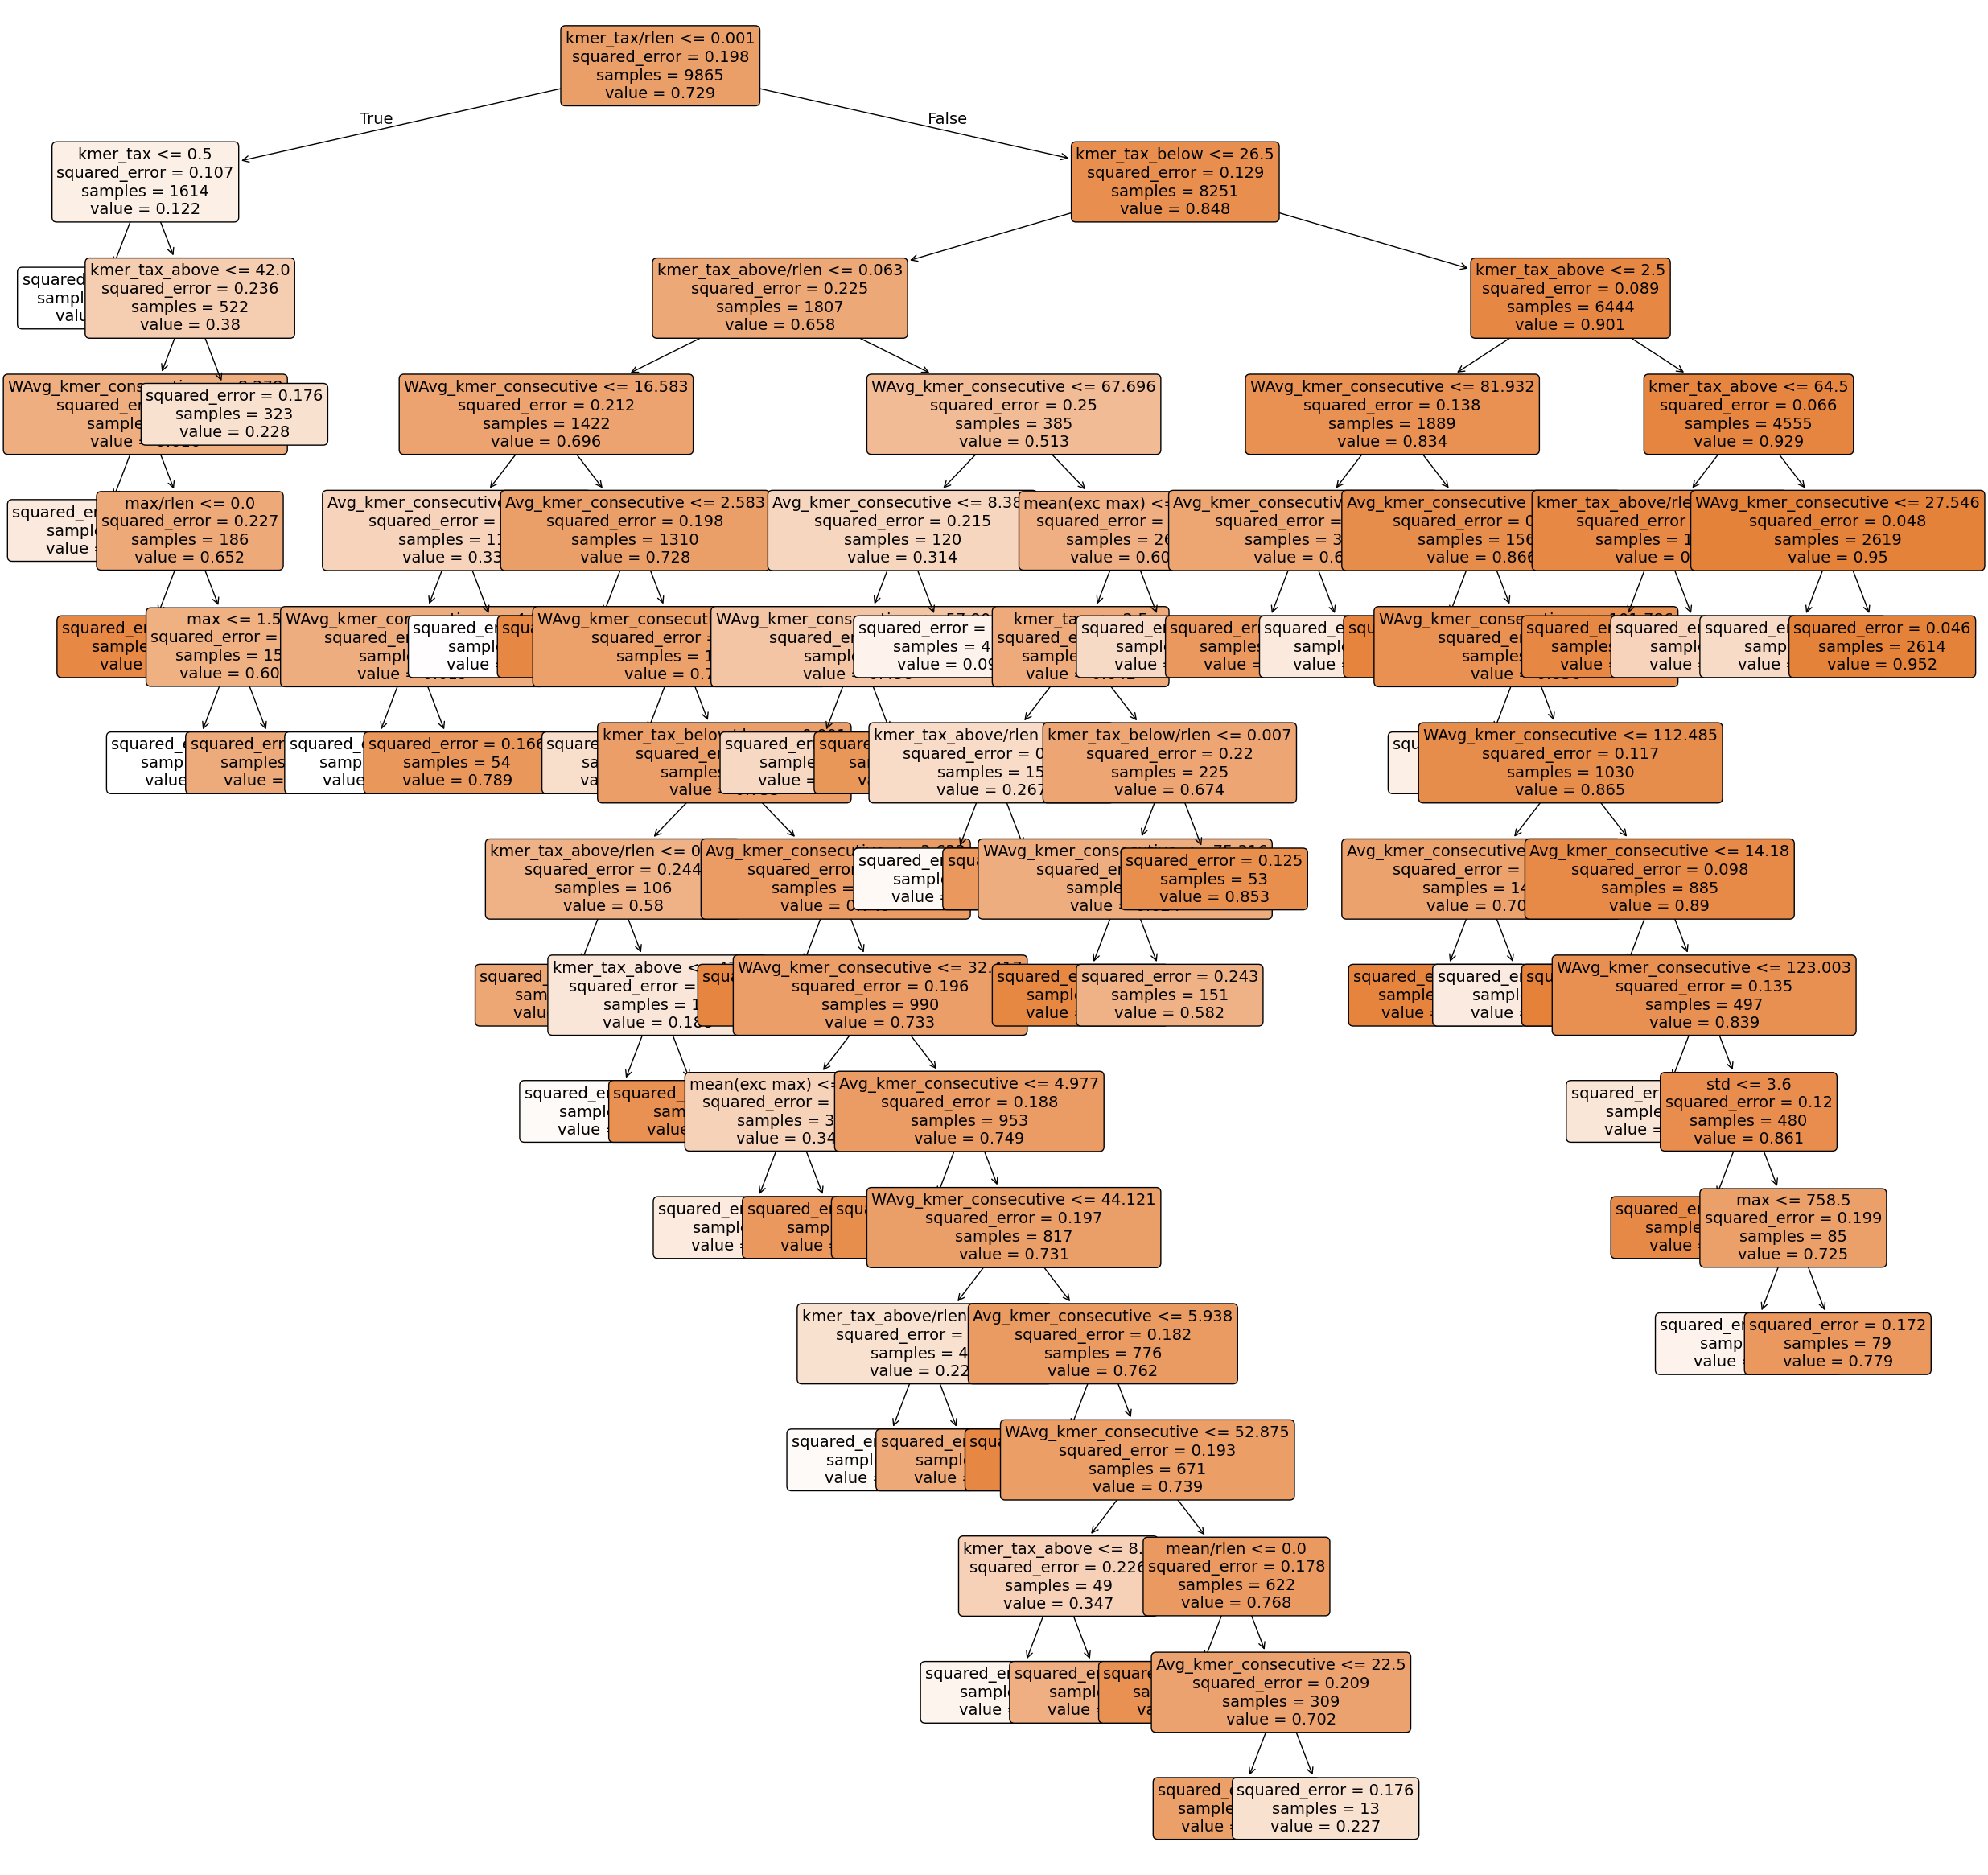

In [535]:
kmer_s='31'
from sklearn import tree
individual_tree = regr_dic['k'+kmer_s].estimators_[0]  # Get the first tree (you can choose any index)
plt.figure(figsize=(30, 30))
tree.plot_tree(individual_tree, filled=True ,rounded=True,fontsize=14, feature_names=feature_names) # , class_names=class_names,
plt.savefig("v4n_25features__regr_tree_0_per_kmer_k"+kmer_s+".png",dpi=100)

In [263]:
len(X_input[0])

25

In [ ]:
# print(regr_dic[case]);
# y_val_pred = regr_dic[case].predict(X_val)


In [ ]:
len(X_val), num_examples_train# ,len(X_val[0])
X_train, X_val = np.split(np.take(X_input,examples_train_indecis,axis=0), [num_examples_train])
len(X_train),len(X_val)

In [340]:
num_examples_val

3927

## impact on validate

In [344]:
# test_size=0.2
# num_examples=19634 # 1000# 19634

# examples_val_indecis=[]
# for i in set(examples_train_indecis):
#     if i not in examples_train_indecis:
#         examples_val_indecis.append(i)

read_names_test = [read_names_[i] for i in test_indecis]

num_examples_val=len(read_names_test)
read_k_prob_val={}
for read_id in read_names_test:
    read_k_prob_val[read_id]=np.zeros(len(cases))

for case_idx,case in enumerate(cases): #='k25' 
    X_input=dic_matrix2[case]#[:1000,:]  #X3#[:,:52229] #np.array(X2c)[:,:10] #X3
    Y_input=dic_y2[case]#[:1000]   # y2[:100]
    
    X_train, X_test = np.split(np.take(X_input,num_examples_permuted,axis=0), [num_examples_train])    
    y_train, y_test = np.split(np.take(Y_input,num_examples_permuted), [num_examples_train])

    X_val = X_test
    y_val= y_test
    
    y_val_pred = regr_dic[case].predict(X_val)
    y_val_pred_binary=np.round(y_val_pred)
    print(sum([1 for i in range(len(y_val_pred)) if y_val_pred_binary[i]==y_val[i]])/len(y_val_pred))


    for ii in range(num_examples_val):
        read_id=read_names_[int(test_indecis[ii])]
        read_k_prob_val[read_id][case_idx]= y_val_pred[ii]
        
best_k_dic_val={}
for ii in range(num_examples_val):
    read_id=read_names_[int(test_indecis[ii])]
    best_k= cases[np.argmax(read_k_prob_val[read_id])]
    best_k_dic_val[read_id]=best_k


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s


0.902724726254138


[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s


0.889737713267125


[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s


0.8775146422205246


[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s


0.8859180035650623


[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [345]:
Counter(best_k_dic_val.values())

Counter({'k21': 2078, 'k19': 989, 'k25': 565, 'k31': 295})

In [343]:
int(test_indecis[ii])

6270

In [334]:
len(best_k_dic_val)

0

In [326]:
Counter(y_val), Counter(y_val_pred_binary)

(Counter({np.int64(1): 2792, np.int64(0): 1135}),
 Counter({np.float64(1.0): 2946, np.float64(0.0): 981}))

In [ ]:
# plt.plot(y_train)

In [346]:
read_names_test = [read_names_[i] for i in test_indecis]

merged2c=merged2a.copy()
merged2c= merged2a[merged2a['read_name'].isin(read_names_test)]
merged2c.reset_index(drop=True, inplace=True)

used=0
alternative_best_k='k25'
new_estimates=[]
new_estimates_random=[]
for index, row in merged2c.iterrows():
    read=row['read_name']    
    if read in best_k_dic_val: 
        new_estimate =  row['taxon_tool_'+best_k_dic_val[read]]
        used+=1
    else:
        new_estimate=row['taxon_tool_'+alternative_best_k]
    new_estimates.append(new_estimate)
    rndm_k=str(cases[random.randint(0, 3)])
    new_estimates_random.append( row['taxon_tool_'+rndm_k])
case1= 'RF_allk'
merged2c[case1]=new_estimates
merged2c['Random_allk']=new_estimates_random
print('number of times RF used',used)
merged2c.head(2)



number of times RF used 3927


/tmp/ipykernel_3319550/3991198962.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged2c[case1]=new_estimates
/tmp/ipykernel_3319550/3991198962.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged2c['Random_allk']=new_estimates_random


,read_name,taxon,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31,oracle_____,RF_allk,Random_allk
0,NZ_PJLY01000023.1__1_1,1292,186817,1385,1385,1385,0,1385,1385
1,NZ_PNYD02000026.1__1_1,562,562,562,0,0,562,562,0


In [348]:
#for case1 in ['taxon_tool_k'+str(k) for k in  [19,21,25,31]]+["oracle_____","RF_allk", "Random_allk" , "RF_allk",'RF_allk_tog']:
for k in [19,21,25,31,2,3,4]:
    case1='taxon_tool_k'+str(k) 
    # if k==0: case1= 'Random_'+k1+'+'+k2
    # if k==1: case1= 'RF_'+k1+'+'+k2
    if k==2: case1="oracle_____"
    if k==3: case1="RF_allk"
    if k==4: case1="Random_allk"
    #case_dic_all[case]
    #print(case1)
    cases_dic_=def_cal(merged2c,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    

taxon_tool_k19 	 0.7426 0.7771 0.711 2792 801 333
taxon_tool_k21 	 0.812 0.8531 0.7746 3042 524 339
taxon_tool_k25 	 0.8385 0.9148 0.7739 3039 283 396
taxon_tool_k31 	 0.8217 0.9406 0.7296 2865 181 426
oracle_____ 	 0.8879 1.0 0.7983 3135 0 0
RF_allk 	 0.8373 0.9068 0.7777 3054 314 549
Random_allk 	 0.8015 0.8626 0.7484 2939 468 369


In [ ]:
np.round([0.55,0.44])

In [ ]:
plt.scatter(y_traing_pred,y_train)
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('Training')

## ExtraTreesRegressor

In [ ]:

ExtraTreesRegressor

## GradientBoostingRegressor

In [ ]:
GradientBoostingClassifier


In [ ]:
 ensemble.GradientBoostingRegressor

# RandomForestClassifier

In [ ]:
X_input=X3#[:,:52229] #np.array(X2c)[:,:10] #X3
Y_input=y2#[:100]
len(Y_input), len(X_input),len(X_input[0])

In [ ]:
# use X or X2
#y=np.array(y2)#[:1000]
indices=range(len(X_input)) # number of reads
X_train, X_test, y_train, y_test, indices_train_tmp, indices_test = train_test_split(X_input, Y_input, indices, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, indices_train_tmp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
# X_train=X[:15000]; y_train=y[:15000];X_test=X[15001:17001];y_test=y[15001:17001]
len(X_train), len(X_train[0])

In [ ]:

classifier2 = RandomForestClassifier(n_estimators=100, 
                                     max_features=12,
                                     max_leaf_nodes=20,
                                     random_state=12, verbose=True,n_jobs=20) 
# {“sqrt”, “log2”, None} max_features=log2(n_features). #criterion="gini" #max_depth=None,  #min_samples_leaf=1 # n_estimators The number of trees in the forest. # X_train=X # y_train=y #max_depth=15,
print("started")
classifier2.fit(X_train, y_train)


In [ ]:
y_traing_pred = classifier2.predict(X_train)
print(sum([1 for i in range(len(y_traing_pred)) if y_traing_pred[i]==y_train[i]])/len(y_train))
sklearn.metrics.confusion_matrix(y_train, y_traing_pred)

In [ ]:
y_val_pred = classifier2.predict(X_val)
print(sum([1 for i in range(len(y_val_pred)) if y_val_pred[i]==y_val[i]])/len(y_val_pred))
sklearn.metrics.confusion_matrix(y_val, y_val_pred)

In [ ]:
sum([1 for i in list(merged2a['taxon_tool_k19']) if i==0])

## impact on train

In [ ]:

read_names_train = [read_names_[i] for i in indices_train]

read_names_validate = [read_names_[i] for i in indices_val]


In [ ]:
import random
read_names_radom={}
for read_name in read_names_train:
    read_names_radom[read_name]= random.randint(0, 1)
    
read_names_train_k1={}
for read_id, read_name in enumerate(read_names_train):
    read_names_train_k1[read_name]= y_traing_pred[read_id]
sum(list(read_names_radom.values())), len(read_names_radom), sum(list(read_names_train_k1.values())), len(read_names_train_k1), 

In [ ]:
k1='25'
k2='31'

merged2b=merged2a.copy()
merged2b= merged2a[merged2a['read_name'].isin(read_names_train)]
merged2b.reset_index(drop=True, inplace=True)
here=0
new_estimates=[]
for index, row in merged2b.iterrows():
    read=row['read_name']
    if read in read_names_train: # selected_k
        if read_names_radom[read]==1:
            here+=1
            new_estimate =  row['taxon_tool_k'+k1]
        else:
            new_estimate =  row['taxon_tool_k'+k2]
    else:
        new_estimate=0
    new_estimates.append(new_estimate)
case1= 'Random_'+k1+'+'+k2 
merged2b[case1]=new_estimates
print(here)
merged2b.head(2)
here=0
new_estimates=[]
for index, row in merged2b.iterrows():
    read=row['read_name']
    if read in read_names_train: # selected_k
        if read_names_train_k1[read]==1:
            here+=1
            new_estimate =  row['taxon_tool_k'+k1]
        else:
            new_estimate =  row['taxon_tool_k'+k2]
    else:
        new_estimate=0
    new_estimates.append(new_estimate)
case1= 'RF_'+k1+'+'+k2 #best/second
merged2b[case1]=new_estimates
print(here)
merged2b.head(2)

In [ ]:
# for case1 in ['taxon_tool_k'+str(k) for k in  [19,21,25,31]]+["oracle_____","RF_allk", "Random_allk" , "RF_allk",'RF_allk_tog']:
for k in [19,21,25,31,0,1,2]:
    case1='taxon_tool_k'+str(k) 
    if k==0:
        case1= 'Random_'+k1+'+'+k2
    if k==1:
        case1= 'RF_'+k1+'+'+k2
    if k==2:
        case1="oracle_____"
    #case_dic_all[case]
    #print(case1)
    cases_dic_=def_cal(merged2b,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    

## impact on validate

In [ ]:
import random
read_names_radom={}
for read_name in read_names_validate:
    read_names_radom[read_name]= random.randint(0, 1)
read_names_train_k1={}
for read_id, read_name in enumerate(read_names_validate):
    read_names_train_k1[read_name]= y_val_pred[read_id]
merged2b=merged2a.copy()
merged2b= merged2a[merged2a['read_name'].isin(read_names_validate)]
merged2b.reset_index(drop=True, inplace=True)
here=0
new_estimates=[]
for index, row in merged2b.iterrows():
    read=row['read_name']
    if read in read_names_validate: # selected_k
        if read_names_radom[read]==1:
            here+=1
            new_estimate =  row['taxon_tool_k'+k1]
        else:
            new_estimate =  row['taxon_tool_k'+k2]
    else:
        new_estimate=0
    new_estimates.append(new_estimate)
case1= 'Random_'+k1+'+'+k2 
merged2b[case1]=new_estimates
print(here)
merged2b.head(2)
here=0
new_estimates=[]
for index, row in merged2b.iterrows():
    read=row['read_name']
    if read in read_names_validate: # selected_k
        if read_names_train_k19[read]==1:
            here+=1
            new_estimate =  row['taxon_tool_k'+k1]
        else:
            new_estimate =  row['taxon_tool_k'+k2]
    else:
        new_estimate=0
    new_estimates.append(new_estimate)
case1= 'RF_'+k1+'+'+k2 
merged2b[case1]=new_estimates
print(here)
merged2b.head(2)

# for case1 in ['taxon_tool_k'+str(k) for k in  [19,21,25,31]]+["oracle_____","RF_allk", "Random_allk" , "RF_allk",'RF_allk_tog']:
for k in [19,21,25,31,0,1,2]:
    case1='taxon_tool_k'+str(k) 
    if k==0: case1= 'Random_'+k1+'+'+k2 
    if k==1: case1= 'RF_'+k1+'+'+k2
    if k==2:case1="oracle_____"        
    #case_dic_all[case]
    #print(case1)
    cases_dic_=def_cal(merged2b,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    

In [ ]:
len(feature_names),len(X3[0])

In [ ]:
len(feature_names)

## Viz the decision tree

In [ ]:
#from sklearn.tree import export_graphviz
#import pydot
# export_graphviz(individual_tree, out_file='4g_individual_tree.dot',rounded=True, filled=True)#,feature_names=iris.feature_names,class_names=iris.target_names,
# (graph,) = pydot.graph_from_dot_file('4g_individual_tree.dot')
# graph.write_png('4g_individual_tree.png')

from sklearn import tree
individual_tree = classifier2.estimators_[1]  # Get the first tree (you can choose any index)
plt.figure(figsize=(30, 30))
tree.plot_tree(individual_tree, filled=True ,rounded=True,fontsize=14, feature_names=feature_names) # , class_names=class_names,
plt.savefig("v4g_tree_1_4h.png",dpi=100)

In [ ]:
read_names_

In [ ]:
Counter(y_train),Counter(y_traing_pred),Counter(y_val),Counter(y_val_pred)

In [ ]:
feature_importances = classifier2.feature_importances_
fig = plt.figure()

plt.hist(feature_importances,bins=50)
#plt.yscale('log')
plt.xlabel('Feature importance value')
plt.ylabel('No. features')


In [ ]:



fig = plt.figure()
max_depth_trees=[estimator.get_n_leaves() for estimator in classifier2.estimators_]
plt.hist(max_depth_trees,bins=20)
plt.xlabel('Num leaves in each decision trees')
plt.ylabel('Number of decision trees out of all trees')

fig = plt.figure()
max_depth_trees=[estimator.tree_.max_depth for estimator in classifier2.estimators_]
plt.hist(max_depth_trees,bins=20)
plt.xlabel('Max depth decision trees')
plt.ylabel('Number of decision trees out of all trees')


In [ ]:



fig = plt.figure()
max_depth_trees=[estimator.get_n_leaves() for estimator in classifier2.estimators_]
plt.hist(max_depth_trees,bins=20)
plt.xlabel('Num leaves in each decision trees')
plt.ylabel('Number of decision trees out of all trees')

fig = plt.figure()
max_depth_trees=[estimator.tree_.max_depth for estimator in classifier2.estimators_]
plt.hist(max_depth_trees,bins=20)
plt.xlabel('Max depth decision trees')
plt.ylabel('Number of decision trees out of all trees')


In [ ]:


featureidx_good=[]
max_importance= max(feature_importances)
for feature_idx, feature_importance in enumerate(feature_importances):
    if feature_importance > max_importance*0.5:
        featureidx_good.append(feature_idx)
len(feature_importances),len(featureidx_good), featureidx_good

In [ ]:
feature_importances

In [ ]:



good_ks=[]
for idx in featureidx_good:
    #good_k
    #if idx < offset_paths:
    case_k= np.floor(idx/ num_paths)
    k=cases[int(case_k)]
    # else:
    #     case_k=np.floor((idx-offset_paths)/num_paths)
    #     k=cases[int(case_k)]+'_sum'
    good_ks.append(k)
print(len(good_ks))
cntr=Counter(good_ks)

fig = plt.figure()

plt.barh(range(len(cntr)), list(cntr.values()))
plt.yticks(range(len(cntr)), list(cntr.keys()))
plt.xlabel('Number of features with high importance (>0.1*max)')
plt.show()



In [ ]:
from sklearn import tree


In [ ]:
fig = plt.figure(figsize=(400, 60))
tree.plot_tree(classifier2.estimators_[0],filled = True, fontsize=28) # feature_names = fn,class_names=cn,
               #feature_names = fn, 
               #class_names=cn,
               
fig.savefig('_individualtree_100_1000_10.png',dpi=100)

In [ ]:
print(len(X_train),len(X_train[0]),len(y_train),len(y_val))
print(len(set(y_train) or set(y_val)), len(set(y_train) and set(y_val)), len(set(y_train).difference(set(y_val))),len(set(y_val).difference(set(y_train))))
#print(len(set(y_train) or set(y_test)), len(set(y_train) and set(y_test)), len(set(y_train).difference(set(y_test))))

In [ ]:
feature_importances = classifier2.feature_importances_
fig = plt.figure()

plt.hist(feature_importances,bins=50)
plt.yscale('log')
plt.xlabel('Feature importance value')
plt.ylabel('No. features')


featureidx_good=[]
max_importance= max(feature_importances)
for feature_idx, feature_importance in enumerate(feature_importances):
    if feature_importance > max_importance*0.1:
        featureidx_good.append(feature_idx)
len(featureidx_good)


good_ks=[]
for idx in featureidx_good:
    #good_k
    if idx < offset_paths:
        case_k= np.floor(idx/len(all_tax))
        k=cases[int(case_k)]
    else:
        case_k=np.floor((idx-offset_paths)/num_paths)
        k=cases[int(case_k)]+'_sum'
    good_ks.append(k)
print(len(good_ks))
cntr=Counter(good_ks)

fig = plt.figure()

plt.barh(range(len(cntr)), list(cntr.values()))
plt.yticks(range(len(cntr)), list(cntr.keys()))
plt.xlabel('Number of features with high importance (>0.1*max)')
plt.show()





fig = plt.figure()
max_depth_trees=[estimator.get_n_leaves() for estimator in classifier2.estimators_]
plt.hist(max_depth_trees,bins=20)
plt.xlabel('Num leaves in each decision trees')
plt.ylabel('Number of decision trees out of all trees')

fig = plt.figure()
max_depth_trees=[estimator.tree_.max_depth for estimator in classifier2.estimators_]
plt.hist(max_depth_trees,bins=20)
plt.xlabel('Max depth decision trees')
plt.ylabel('Number of decision trees out of all trees')


In [ ]:

classifier = RandomForestClassifier(n_estimators=10, random_state=12, verbose=True,
                                    max_features=1000, n_jobs=20, max_depth=1000) 
# {“sqrt”, “log2”, None} max_features=log2(n_features).
#criterion="gini"
#max_depth=None, 
#min_samples_leaf=1
# n_estimators The number of trees in the forest.
# X_train=X
# y_train=y

print("started")
classifier.fit(X_train, y_train)

In [ ]:
y_traing_pred = classifier.predict(X_train)
sum([1 for i in range(len(y_traing_pred)) if y_traing_pred[i]==y_train[i]])/len(y_train)

In [ ]:
len(set(y))

In [ ]:
y_val_pred = classifier.predict(X_val)

In [ ]:
y_val_pred = classifier.predict(X_val)
sum([1 for i in range(len(y_val_pred)) if y_val_pred[i]==y_val[i]])/len(y_val_pred)

In [ ]:
len(set(y_train)),len(y_train)

In [ ]:

# tax_level='species'
# tax_l_list=[]
# tax_true_test={}
# tax_list=[]
# all_tax_set=set(all_tax)
# read_name_species_lower = set()
# for index, row in merged.iterrows():
#     read_id = row['read_name']
#     tax_true = row['taxon']
#     tax_true_level= find_tax_level(info,tree_df,parents, tax_true, tax_level)
#     if tax_true_level!=1 and tax_true_level in all_tax_set:
#         read_name_species_lower.add(read_id)
#         tax_l_list.append(tax_true_level)
#         tax_list.append(tax_true)
#         tax_true_test[read_id]=tax_true
# print(len(read_name_species_lower), len(merged))


# merged1a=merged.copy()
# merged1a= merged1a[merged1a['read_name'].isin(read_name_species_lower)]
# merged1a.reset_index(drop=True, inplace=True)

# len(merged1a)


# notfndd=0
# merged2=merged1a.copy()
# read_names_=read_names_test #list(predicted_tax.keys())
# print(len(read_names_))
# merged2a= merged2[merged2['read_name'].isin(read_names_)]
# merged2a.reset_index(drop=True, inplace=True)

# new_estimates=[]
# for index, row in merged2a.iterrows():
#     read=row['read_name']
#     if read in predicted_tax:
#         new_estimates.append(predicted_tax[read])
#     else:
#         new_estimates.append(0)
#         notfndd+=1
# print(notfndd)
# case1= "taxon_randomforst" #best/second
# merged2a[case1]=new_estimates
# merged2a



# #case1='taxon_best/second'
# #case_dic_all[case]
# cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
# #cases_dic_ = case_dic_all[case]
# FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
# recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
# precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
# F1=0
# if (precision+recall):
    
#     F1= 2* precision* recall/(precision+recall)
# print('F1', "precision",'recal','TP','FP','VP')
# print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))



# case1='taxon_tool_k31'
# cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
# #cases_dic_ = case_dic_all[case]
# FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
# recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
# precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
# F1=0
# if (precision+recall):
    
#     F1= 2* precision* recall/(precision+recall)
# print('F1', "precision",'recal','TP','FP','VP')
# print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))


In [ ]:


# print(classification_report(y_val_pred, y_val))

# param_grid = {
#     'max_features':[5,100,'log2'],
#     'n_estimators': [10, 50, 200,1000,5000],
#     'max_depth': [None, 10, 50,500,1000],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'bootstrap': [True, False]
# }
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# random_search = RandomizedSearchCV(RandomForestClassifier(),
#                                    param_grid, n_jobs=20)
# random_search.fit(X_train, y_train)
# print(random_search.best_estimator_)


In [ ]:
# from sklearn.model_selection import cross_val_score, KFold
# #from sklearn.svm import SVC
# from sklearn.datasets import load_iris
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# cross_val_results = cross_val_score(classifier, X_train, y_train, cv=kf)

In [ ]:
# print("Cross-Validation Results (Accuracy):")
# for i, result in enumerate(cross_val_results, 1):
#     print(f"  Fold {i}: {result * 100:.2f}%")
    
# print(f'Mean Accuracy: {cross_val_results.mean()* 100:.2f}%')

In [ ]:
y_test_pred = classifier.predict(X_test)

In [ ]:
sum([1 for i in range(len(y_test_pred)) if y_test_pred[i]==y_test[i]])/len(y_test_pred)

In [ ]:

# plt.barh(range(len(feature_importances)), feature_importances)
# plt.xlabel('Feature Importance')
# plt.title('Feature Importance in Random Forest Classifier')
# plt.show()


In [ ]:
int(case_k)

In [ ]:
individual_tree.get_params()

In [ ]:
# from sklearn import tree
# plt.figure(figsize=(15, 10))
# tree.plot_tree(individual_tree, filled=True ,rounded=True) # , feature_names=feature_names, class_names=class_names,
# plt.savefig("500_100.png")

## GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=300,learning_rate=0.05,random_state=100, max_features=5 ,verbose=True)
                                 
gbc.fit(X_train, y_train)


In [ ]:
y_traing_pred = classifier.predict(X_train)
sum([1 for i in range(len(y_traing_pred)) if y_traing_pred[i]==y_train[i]])/len(y_train)


In [ ]:

y_val_pred = classifier.predict(X_val)
sum([1 for i in range(len(y_val_pred)) if y_val_pred[i]==y_val[i]])/len(y_val_pred)

# Test cami

In [350]:
folder+case+"_out"

'/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0/small/k31_out'

In [360]:
#folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/reads_sample_48_species/standard/" 

folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0/small/" # 

#cases_test=[i.split("_")[0] for i in os.listdir(folder) if i.endswith('_out')] #["k"+str(k) for k in range(15,32)]
cases_test=["k19","k21", "k25", "k31"] #"k16", "k17",
dic_cases_test["k31"]=read_kraken_limited(folder+case+"_out",10000)
read_names_test=set(dic_cases_test['k21'].keys())
print(len(reads_a),list(reads_a)[:3])

dic_cases_test={}
for case in reversed(cases_test): # 
    print(case)
    try:
        dic_cases_test[case]=read_kraken_set(folder+case+"_out",read_names_test)
        #dic_cases_test[case]=read_kraken(folder+case+"_out")
    except:
        print("n",case)
    print(case,len(dic_cases_test[case]))

9996 ['S0R1299', 'S0R8851', 'S0R6536']
k31
k31 3387
k25
k25 8940
k21
k21 9996
k19
k19 9996


In [362]:
read_names_test=list(reads_a)

In [361]:
fastq_file_cami= "/vast/blangme2/smajidi5/metagenomics/camii2/plant_associated/long_read/simulation_pbsim/2019.11.04_11.02.31_sample_0/reads/anonymous_reads.fq"
read_length_dic_cami= read_len_dic(fastq_file_cami)
read_id=list(read_length_dic_cami.keys())[0]
read_id, read_length_dic_cami[read_id]

1691142  reads


('S0R0', 3910)

In [ ]:
# read_names_test_raw= []
# for case_k, case in  enumerate(cases_test): 
#     read_names_test_raw+= list(dic_cases_test[case].keys())
# read_names_test= list(set(read_names_test_raw))
# len(read_names_test)

In [369]:

X_tst=np.zeros((len(read_names_test),num_features),dtype=np.int32)
not_found_path2_tst=[]

XP_tst=np.zeros((len(read_names_test),num_features_XP),dtype=np.int32)
for read_idx, read_id in enumerate(read_names_test):
    if read_idx%2000==0:
        print(read_idx,len(read_names_test))
    for case_k, case in  enumerate(cases): 
        if read_id in dic_cases_test[case]:            
            dic_tax_value_={}        
            tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases_test[case][read_id]
            
            for tax_, num_kmer in tax_kmer_num_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
                if tax_==0: continue 
                tax = tax_
                # if tax_ is lower than species make it species, if deeper no change
                if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
                    tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
                #num_kmer = sum([i[1] for i in pos_num]) #(position, num_kmer )
                if tax in tax2idx_dict:
                    tax_idx= tax2idx_dict[tax]
                    columnid = case_k*num_lable_perk  + tax_idx #tax2root_path_idx #tax_idx
                    X_tst[read_idx][columnid] += num_kmer
                else:
                    not_found_internal2.append(tax)
                #if tax in [1,2,131567,10239,9606 ]: 
                #   continue
                if  tax in tax2path:
                    all_path_including_tax= tax2path[tax]
                    for tax2root_path_idx in all_path_including_tax:
                        columnid = num_paths*case_k + tax2root_path_idx #tax_idx
                        XP_tst[read_idx][columnid] += num_kmer
                else:
                    not_found_path2_tst.append(tax)

print('number of reads',len(X),'number of features',len(X_tst[read_idx]),'number of taxa not found ',len(not_found_path2_tst), 'from ',len(set(not_found_path2_tst)),' unique tax ids' ,len(not_found_internal2), len(set(not_found_internal2)))
# in bacteria




0 9996
2000 9996
4000 9996
6000 9996
8000 9996
number of reads 19634 number of features 208916 number of taxa not found  589 from  17  unique tax ids 120 3


In [537]:
# with open('v4n_X_tst_XP_tst_.pickle', 'wb') as handle:
#     pickle.dump((X_tst,XP_tst), handle, protocol=pickle.HIGHEST_PROTOCOL)



In [370]:
read_length_dic_tst= read_length_dic_cami

In [371]:
dic_matrix2_tst={}
for case in cases: 
    X3_tst=[]
    for read_idx,read_id in enumerate(read_names_test):
        if read_idx%2000==0:
            print(read_idx,len(read_names_test))
        k1=cases.index(case)
        kmer= int(case[1:])
        row_raw=np.array(XP_tst[read_idx,num_paths*k1:num_paths*(k1+1)])
        row_raw_norm=row_raw/read_length_dic_tst[read_id]
        description=list(pd.DataFrame(row_raw).describe()[0])
        description_norm=list(pd.DataFrame(row_raw_norm).describe()[0])
        row=description[1:] #[ii/read_length_dic[read_id] for ii in description[1:]] # count,mean, std,min,25, max
        row+=description_norm[1:]
        #row+=[sum(row_raw)/read_length_dic[read_id]] # ,read_length_dic[read_id] ,np.mean(row_raw)/read_length_dic[read_id]
        if read_id in read_tax_depth:
            txdepth_norm= read_tax_depth[case][read_id]
        else:
            txdepth_norm=0
        row+=[txdepth_norm, (num_paths*description[1] - description[-1])/num_paths] # Mean without the max=  (num_paths*mean -max )/num1|    
        numkmer_consecutive_mean=0
        weighted_depth_numkmer_mean=0
        kmer_read_reported_tax=0
        kmer_read_reported_uppertax=0 #(towards root
        kmer_read_reported_belowtax=0 # towards leaves
        if read_id in dic_cases_test[case]:            
            tax_krak, read_len, tax_kmer_dic, tax_kmer_num_dic = dic_cases_test[case][read_id]
            #assert read_length_dic[read_id]==read_len, 'read_id'+read_id+' '+case
            numkmer_consecutive=[]
            weighted_depth_numkmer =[]
            for tax, pos_num in tax_kmer_dic.items():
                numkmer_consecutive += [i[1] for i in pos_num] # how many kmer are one after each other (~ length of math)
                if tax in tax2depth:
                    tax_depth=tax2depth[tax] 
                    weighted_depth_numkmer += [i[1]*tax_depth for i in pos_num]
            if weighted_depth_numkmer: weighted_depth_numkmer_mean= np.mean(weighted_depth_numkmer)
            if numkmer_consecutive: numkmer_consecutive_mean=np.mean(numkmer_consecutive)
                
            if tax_krak in tax_kmer_num_dic:
                kmer_read_reported_tax = tax_kmer_num_dic[tax_krak] 
            else:
                kmer_read_reported_tax=0 # probably this kraken tax is the lca of a few tax closer to leaves
            
            tax_krak_2root= find_tax2root(info, parents, tax_krak)
            for tax_upper in tax_krak_2root[1:]: #excluding tax_krak towards the root  tax_krak_2root = [201174, 1783272, 2, 131567, 1] where tax_krak=201174 
                if tax_upper in tax_kmer_num_dic: 
                    kmer_read_reported_uppertax +=tax_kmer_num_dic[tax_upper]
            # kmer_read_reported_belowtax
            below_tax_all_perread=[]
            for taxi in tax_kmer_num_dic:
                tax2root_t= find_tax2root(info, parents, taxi)
                if tax2root_t!=-1 and tax_krak in tax2root_t: # tax_krak is lca of taxi
                    kmer_read_reported_belowtax += tax_kmer_num_dic[taxi]   
                    below_tax_all_perread.append(taxi)

        row+=[numkmer_consecutive_mean, weighted_depth_numkmer_mean,
              kmer_read_reported_tax/read_len, kmer_read_reported_uppertax/read_len,kmer_read_reported_belowtax/read_len, 
              kmer_read_reported_tax, kmer_read_reported_uppertax,kmer_read_reported_belowtax]

        #diff_half=None # larger difference means that one part of read is assigned to one but not the other 
        tax_krak_touse=tax_krak
        if tax_krak not in tax_kmer_dic: # when lca is reprorted, use onf its lower ones. 
            tax_krak_touse= below_tax_all_perread[0]
        
        segment_num=2 # 3
        segment_len=int(read_len/segment_num)
        # segs=[]; for seg_i in range(segment_num): segs.append((seg_i*segment_len ,(seg_i+1)*segment_len)) # print(read_len,segs)
        #for tax, pos_num in tax_kmer_dic.items(): numkmer_consecutive += [i[1] for i in pos_num] 
        pos_num_reportedtax = tax_kmer_dic[tax_krak_touse] # [(77, 1), (136, 4), (139, 2), (144, 4), (148, 2), (162, 2), (233, 1)]
        cnt_perbin=np.zeros((segment_num,1))
        for pos,numkmer in pos_num_reportedtax:
            bin_idx= int(pos/segment_len)
            cnt_perbin[bin_idx]+=numkmer
        diff_fromnext_seg = [ np.abs(cnt_perbin[segment_i+1]-cnt_perbin[segment_i])[0] for segment_i in range(segment_num-1)]
        row+=[np.mean(diff_fromnext_seg)]
        
        X3_tst.append(row)
    X3_tst=np.array(X3_tst)
    dic_matrix2_tst[case]=X3_tst
len(X_tst),len(X_tst[0]),len(X3_tst),len(X3_tst[0])

0 9996
2000 9996
4000 9996
6000 9996
8000 9996
0 9996
2000 9996
4000 9996
6000 9996
8000 9996
0 9996
2000 9996
4000 9996
6000 9996
8000 9996
0 9996
2000 9996
4000 9996
6000 9996
8000 9996


(9996, 208916, 9996, 25)

In [538]:
# with open('v4n_dic_matrix2_tst_.pickle', 'wb') as handle:
#     pickle.dump(dic_matrix2_tst, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [376]:

num_examples_tst=len(read_names_test)
read_k_prob_tst={}
read_names_test_tmp=[]
for read_idx, read_id in enumerate(read_names_test):
    read_k_prob_tst[read_id]=np.zeros(len(cases))
    read_names_test_tmp.append(read_id)

for case_idx,case in enumerate(cases): #='k25' 
    X_input=dic_matrix2_tst[case]
    
    y_tst_pred = regr_dic[case].predict(X_input)
    y_tst_pred_binary=np.round(y_tst_pred)
    
    for ii in range(num_examples_tst):
        read_id=read_names_test_tmp[ii]
        read_k_prob_tst[read_id][case_idx]= y_tst_pred[ii]
        


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elaps

Counter({'k25': 4550, 'k21': 2439, 'k19': 1764, 'k31': 1243})

In [495]:
best_k_dic_tst2={}
all_pr=[]
thr=0.90
for ii in range(num_examples_tst):
    read_id=read_names_test_tmp[ii]
    max_val = np.max(read_k_prob_tst[read_id])
    all_pr.append(max_val)
    if max_val >thr:
        best_k= cases[np.argmax(read_k_prob_tst[read_id])]
    else:
        best_k=0
    best_k_dic_tst2[read_id]=best_k
Counter(best_k_dic_tst2.values())

Counter({0: 9972, 'k19': 19, 'k25': 4, 'k31': 1})

Text(0, 0.5, 'No. reads')

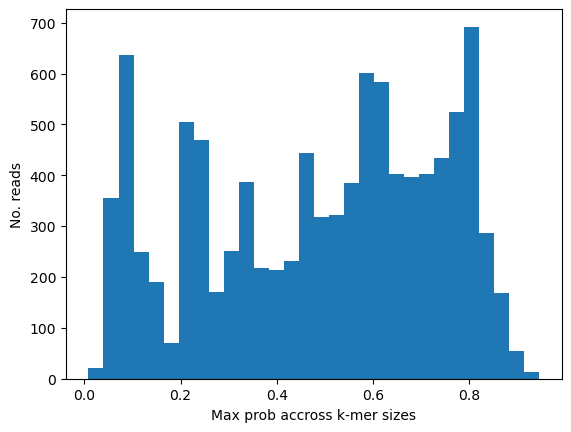

In [462]:
plt.hist(all_pr,bins=30)
#plt.yscale('log')
plt.xlabel('Max prob accross k-mer sizes')
plt.ylabel('No. reads')

4 9996


([<matplotlib.axis.XTick at 0x155082f4be60>,
 [Text(1, 0, 'k19'), Text(2, 0, 'k21'), Text(3, 0, 'k25'), Text(4, 0, 'k31')])

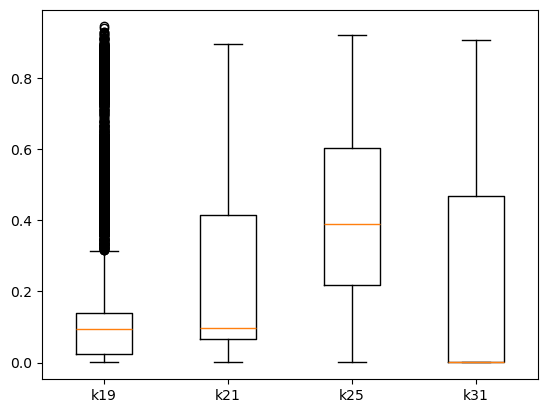

In [392]:
read_k_prob_box_tst=[[],[],[],[]]
for r, prob_l in read_k_prob_tst.items():
    for prob_l_idx, prob_l_i in enumerate(prob_l):
        read_k_prob_box_tst[prob_l_idx].append(prob_l_i)
print(len(read_k_prob_box_tst),len(read_k_prob_box_tst[0]))
plt.boxplot(read_k_prob_box_tst)
plt.xticks([1,2,3,4],cases)

### old 

In [ ]:
# read_names_test_raw[:2]

In [ ]:
# X_test_cam2=X_test_cam

In [ ]:
# #read_name_list=list(readids_max2)
# read_names_test_=read_names_test#[:5000]  #read_name_list#[:1000]
# num_paths=len(tax_genome_level_bact_lst)
# num_possible_lables=num_paths
# num_features= num_possible_lables*len(cases)
# X_test_cam=np.zeros((len(read_names_test_),num_features),dtype=np.int32)
# not_found_path_bact=[]
# for read_idx, read_id in enumerate(read_names_test_):
#     if read_idx%1000==0:
#         print(read_idx,len(read_names_test_))
#     for case_k, case in  enumerate(cases): 
#         if read_id in dic_cases_test[case]:            
#             dic_tax_value_={}        
#             tax_krak, read_len, tax_kmer_dic = dic_cases_test[case][read_id]
            
#             for tax_, pos_num in tax_kmer_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
#                 if tax_==0: continue 
#                 tax = tax_
#                 # if tax_ is lower than species make it species, if deeper no change
#                 if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
#                     tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
#                 num_kmer = sum([i[1] for i in pos_num]) #(position, num_kmer )

#                 #if tax in [1,2,131567,10239,9606 ]: 
#                 #    continue
#                 if    tax in tax2path:
#                     all_path_including_tax= tax2path[tax]
#                     for tax2root_path_idx in all_path_including_tax:
#                         columnid = (case_k-1)*num_paths  + tax2root_path_idx #tax_idx
#                         X_test_cam[read_idx][columnid] += num_kmer
#                 else:
#                     not_found_path_bact.append(tax)

# print('number of reads',len(X_test),'number of features',len(X_test_cam[read_idx]),
#       'number of taxa not found in bacteria',len(not_found_path_bact), 'uniq tax',len(set(not_found_path_bact)))

In [ ]:
X_test_cam=np.load('X_test_cami_5k_v4d.npy')

In [ ]:
len(X_test_cam),len(X_test_cam[0])

In [ ]:
len(X_test_cam[0])/4

In [ ]:
X_test_cam2=X_test_cam[:5000,:13862]

In [ ]:
X_test_cam3=[]
for read_idx,read_id in enumerate(read_names_test[:5000]):
    row=list(pd.DataFrame(X_test_cam2[read_idx]).describe()[0]) # count,mean, std,min,25, max
    #row.append(read_length_dic_cami[read_id])
    row+=[sum(X_test_cam2[read_idx]),sum(X_test_cam2[read_idx])/read_length_dic_cami[read_id],np.mean(X_test_cam2[read_idx])/read_length_dic_cami[read_id],read_length_dic_cami[read_id]]
    X_test_cam3.append(row)

In [ ]:
len(read_names_test), len(X_test_cam3), len(X_test_cam3[0])

In [ ]:
# # np.save('X_test_cami_5k_v4d',X_test_cam)
# len(y_pred_test)

In [ ]:
classifier2

In [ ]:
y_pred_test = classifier2.predict(X_test_cam3)


In [ ]:
Counter(y_pred_test)

In [ ]:
# plt.hist(X_test_cam3

In [ ]:
for i, j in Counter(y_pred_test).items():
    print(all_combinations[int(i)], j)

In [ ]:
for i, j in sorted(Counter(y2a).items()):
    print(all_combinations[int(i)], j)

In [ ]:
# for i,cnt in dict(Counter(y_pred_test)):
#     print(all_combinations[int(i)],cnt)

In [ ]:
for i, j in enumerate(all_combinations):
    print(i, j )

In [ ]:
sum([1 for i in range(len(y_pred_test)) if y_pred_test[i]==y_test[i]])/len(y_pred_test)

In [ ]:
#dic_idx_tax = {v: k for k, v in dic_tax_idx.items()}
predicted_k= {}
for read_idx, read_id in enumerate(read_names_test_):
    k_comb_idx= y_pred_test[read_idx]
    max_k=max(all_combinations[k_comb_idx])
    predicted_k[read_id]=max_k
len(predicted_k)    

In [ ]:
# #dic_tax_idx[1831]
# #tax_level_dic[1831]
# case=cases_test[4]
# read_id="S1_111_taxon:470"
# print(case, read_id)
# tax_krak, read_len, tax_kmer_dic = dic_cases_test[case][read_id]
# tax_kmer_dic

In [ ]:
# for tax_, pos_num in tax_kmer_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
#     if tax_==0: continue 
#     tax=tax_
#     if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
#         tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
#     num_kmer = sum([i[1] for i in pos_num]) #(position, num_kmer )
#     if tax in dic_tax_idx:
#         found_t+=1
#         tax_idx=dic_tax_idx[tax]
#         #rowid= tax_idx
#         columnid= (case_k-1)*len(all_tax) + tax_idx
#         print(tax_,tax,columnid)


In [ ]:
cases_test=["k19","k21", "k25", "k31"] #"k16", "k17",


In [ ]:
# read_names_test_=list(read_name_species_lower)[:1000]

# X_test=np.zeros((len(read_names_test_),(len(all_tax)+len(tax2root_all))*(len(cases_test))),dtype=np.int32)# 
# offset_paths= len(cases_test)*len(all_tax)
# num_paths=len(tax2root_all)
# tax_level='species'
# for read_idx, read_id in enumerate(read_names_test_):
#     if read_idx%1000==0:
#         print(read_idx,len(read_names_test_)) #case=cases[-1]    
#     for case_k, case in  enumerate(cases_test): 
#         if read_id in dic_cases_test[case]: # classified with this k
#             dic_tax_value_={}         #for tax in all_tax: dic_tax_value_[tax] = 0        
#             tax_krak, read_len, tax_kmer_dic = dic_cases_test[case][read_id]
#             for tax_, pos_num in tax_kmer_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
#                 if tax_==0: continue 
#                 tax = tax_
#                 if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
#                     tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
#                 num_kmer = sum([i[1] for i in pos_num]) #(position, num_kmer )
#                 if tax in dic_tax_idx:
#                     tax_idx=dic_tax_idx[tax]
#                     #rowid= tax_idx
#                     columnid= (case_k-1)*len(all_tax) + tax_idx
#                     X_test[read_idx][columnid] += num_kmer
#                     # becuase another tax_ can have the same tax (at species level)
#                     #if tax!=1
#                     for tax2root_path_idx in tax2path[tax]:
#                         columnid= offset_paths+ (case_k-1)*num_paths  + tax2root_path_idx #tax_idx
#                         X_test[read_idx][columnid] += num_kmer

# len(X),len(X[read_idx])

In [ ]:
# found_t=0
# X_test=np.zeros((len(read_names_test),len(all_tax)*len(cases_test)))# 
# tax_level='species'
# for read_idx, read_id in enumerate(read_names_test):
    
#     if read_idx%1000==0:
#         print(read_idx,len(read_names_test))
#     #case=cases[-1]
#     for case_k, case in  enumerate(cases_test): 
#         if read_id in dic_cases_test[case]:
#             tax_krak, read_len, tax_kmer_dic = dic_cases_test[case][read_id]
#             for tax_, pos_num in tax_kmer_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
#                 if tax_==0: continue 
#                 tax=tax_
#                 if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
#                     tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
#                 num_kmer = sum([i[1] for i in pos_num]) #(position, num_kmer )
#                 if tax in dic_tax_idx:
#                     found_t+=1
#                     tax_idx=dic_tax_idx[tax]
#                     #rowid= tax_idx
#                     columnid= (case_k-1)*len(all_tax) + tax_idx
#                     X_test[read_idx][columnid] = num_kmer
#                 else:
#                     not_found_tax.append(tax_)
# len(X_test),len(X_test[read_idx])

In [ ]:
# len(not_found_tax), found_t

In [ ]:
# X_test_0 = np.sum(X_test, axis = 0)
# plt.hist(X_test_0,bins=100)
# # X_test_1 = np.sum(X_test, axis = 1)
# # plt.hist(X_test_1,bins=100)
# plt.yscale('log')

In [ ]:
# X_test_1 = np.sum(X_test, axis = 1)
# plt.hist(X_test_1,bins=100)
# # X_test_1 = np.sum(X_test, axis = 1)
# # plt.hist(X_test_1,bins=100)
# plt.yscale('log')

In [ ]:
len(Counter(y_pred))

In [ ]:
sum([1 for i in range(len(y_pred)) if y_pred[i]==y_test[i]])/len(y_pred)

In [ ]:
read_names_test[0]

In [ ]:
# #from collections import Counter

# y_test=[]
# for read_idx, read_id in enumerate(read_names_test):
#     y_test.append(tax_true_test[read_id])


# Not true, we need their index 

# # Counter(y_test)


In [ ]:
# indices_test=list(range(len(read_names_test)))
# predicted_tax= {}
# #for idx_idx, idx_value in enumerate(indices_test):
#     read_id = read_names[idx_value]
#     tax= dic_idx_tax[y_pred[idx_idx]]
#     predicted_tax[read_id]=tax
# len(predicted_tax)

In [ ]:
# dic_idx_tax = {v: k for k, v in dic_tax_idx.items()}
# predicted_tax= {}
# for read_idx, read_id in enumerate(read_names_test):
#     tax= dic_idx_tax[y_pred[read_idx]]
#     predicted_tax[read_id]=tax
# len(predicted_tax)    

In [ ]:
 predicted_tax[read_id]

In [ ]:
       # dic_tax_value_={}        
       #  for tax in all_tax:
       #      dic_tax_value_[tax]=0            
       #  for tax_, pos_num in tax_kmer_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
       #      if tax_==0: continue #num = sum([i[1] for i in pos_num])
       #      tax=tax_
       #      if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
       #          tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
       #      num = sum([i[1] for i in pos_num]) #(position, num_kmer )
       #      if tax in dic_tax_value_:
       #          dic_tax_value_[tax]+=num 
# read_names_=read_names#[:1000]
# y=[]
# for read_idx, read_id in enumerate(read_names_):
#     true_tax=true_tax_all[read_id]
#     y.append(int(dic_tax_idx[true_tax]))

# y=np.array(y)

# print('y',len(y))
# not_found_tax=[]
# X=np.zeros((len(read_names_),len(all_tax)*len(cases)))# 
# tax_level='species'
# for read_idx, read_id in enumerate(read_names_):
    
#     if read_idx%1000==0:
#         print(read_idx,len(read_names_))
#     #case=cases[-1]
#     for case_k, case in  enumerate(cases): 
#         if read_id in dic_cases[case]:
#             tax_krak, read_len, tax_kmer_dic = dic_cases[case][read_id]
#             for tax_, pos_num in tax_kmer_dic.items(): # 0:[], 1236: [(87, 1), (115, 3), (144, 1), (172, 5), (480, 1), (671, 8), (922, 2)], 550: [(359, 1)],
#                 if tax_==0: continue 
#                 tax=tax_
#                 if tax_ in tax_level_dic and tax_level_dic[tax_]>1:
#                     tax =  tax_level_dic[tax_] # =tax_taxlevel #find_tax_level(info,tree_df, parents, tax_, tax_level)  # level or highe
#                 num_kmer = sum([i[1] for i in pos_num]) #(position, num_kmer )
#                 if tax in dic_tax_idx:
#                     tax_idx=dic_tax_idx[tax]
#                     #rowid= tax_idx
#                     columnid= (case_k-1)*len(all_tax) + tax_idx
#                     X[read_idx][columnid] += num_kmer
#                 else:
#                     not_found_tax.append(tax_)
# len(X),len(X[read_idx])       #      else:
       #          not_found1.append(tax_)   
       #      #print(tax_,tax,dic_tax_value_[tax])
       #  scores=[]
       #  tax2root_path_num_all=[]
       #  all_xx=[]
       #  for tax2root_path in tax2root_all:
       #      weight=[ 1 for i in range(len(tax2root_path))]# 2**( len(tax2root_path)-i
       #      tax2root_path_num= [dic_tax_value_[taxx] for taxx in tax2root_path]
       #      score= int(np.dot(tax2root_path_num,weight)) #sum(tax2root_path_num) #np.dot([1,2,3],[10,20,30])=140
       #      scores.append(score)
       #  for tax2root_path in tax2root_all:
  

## truth test

In [377]:
truth_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0_reads_mapping.csv"
folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0/" # 
#truth_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/short_1_reads_mapping.csv"
#truth_file="/vast/blangme2/smajidi5/metagenomics/pseudomonadota_48genomes/sample_48_species.truth_noheader.csv"
# folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/reads_sample_48_species/standard/" 
#folder="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/reads_sample_48_species/48genomes/" 

cases_test=[i.split("_")[0] for i in os.listdir(folder) if i.endswith('_out')] #["k"+str(k) for k in range(15,32)]
#cases=cases[-2:]
# for k in range(20,26):
#     cases.append("k"+str(k)+"l15")
print(len(cases_test),cases_test)
tool_res_files=[]
print(folder)
for case in cases_test: 
    f=folder+case+"_out.csv"
    tool_res_files.append(f)
len(tool_res_files)

6 ['k16', 'k17', 'k19', 'k21', 'k25', 'k31']
/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0/


6

In [378]:
merged_cami = pd.read_csv(truth_file, names=["read_name", "taxon"])
for f in tool_res_files:
    c=f.split("/")[-1][1:3]
    print(c)
    merged_cami_ = pd.read_csv(f, names=["read_name", "taxon_tool_k"+c],sep=",")
    merged_cami = pd.merge(merged_cami, merged_cami_, on="read_name")

merged_cami.head(2)


/tmp/ipykernel_3319550/3687335611.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_cami = pd.read_csv(truth_file, names=["read_name", "taxon"])


16
17
19
21
25
31


,read_name,taxon,taxon_tool_k16,taxon_tool_k17,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31
0,S0R0,1419583,3043441,196821,3398358,3398358,286,3398358
1,S0R1,384,1236,3094846,2918527,2018689,379,0


In [397]:
for f in tool_res_files:
    c=f.split("/")[-1][1:3]
    merged_cami["taxon_tool_k"+c]=merged_cami["taxon_tool_k"+c].astype(int)
merged_cami["taxon"]=merged_cami["taxon"].astype(int)

In [416]:
row['taxon_tool_'+best_k_dic_tst[read]]

29580

In [406]:
merged_camia= merged_cami[merged_cami['read_name'].isin(read_names_test)]
merged_camia.reset_index(drop=True, inplace=True)
len(merged_camia)

9996

In [496]:
used=0
alternative_best_k='k31'
new_estimates=[]
new_estimates_random=[]
new_estimates2=[]
for index, row in merged_camia.iterrows():
    read=row['read_name']    
    if read in best_k_dic_tst: 
        new_estimate =  row['taxon_tool_'+best_k_dic_tst[read]]

        new_estimate2=0
        if best_k_dic_tst2[read]!=0:
            new_estimate2=row['taxon_tool_'+best_k_dic_tst[read]]            
        used+=1
    else:
        new_estimate=-10 # row['taxon_tool_'+alternative_best_k]
    new_estimates.append(new_estimate)
    new_estimates2.append(new_estimate2)
    rndm_k=str(cases[random.randint(0, 3)])
    new_estimates_random.append( row['taxon_tool_'+rndm_k])
case1= 'RF_allk'
merged_camia[case1]=new_estimates
merged_camia['Random_allk']=new_estimates_random
merged_camia["Random_allkthr.2"]=new_estimates2
#print(here)
print('number of times RF used',used)
merged_camia.head(2)



number of times RF used 9996


/tmp/ipykernel_3319550/3621246144.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_camia[case1]=new_estimates
/tmp/ipykernel_3319550/3621246144.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_camia['Random_allk']=new_estimates_random
/tmp/ipykernel_3319550/3621246144.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,read_name,taxon,taxon_tool_k16,taxon_tool_k17,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31,RF_allk,Random_allk,oracle_____,Random_allk_thr0.5,Random_allkthr.5,Random_allkthr.2
0,S0R0,1419583,3043441,196821,3398358,3398358,286,3398358,286,3398358,0,286,286,0
1,S0R1,384,1236,3094846,2918527,2018689,379,0,379,379,0,379,379,0


In [408]:
case_dic_all_tst={}
for case in cases:
    case1= 'taxon_tool_'+case
    case_dic_all_tst[case]=def_cal(merged_camia,info,tree_df,parents,'species',case1,tax_index) #+case
print(len(case_dic_all_tst),len(case_dic_all_tst[case])),len(case_dic_all_tst[case]['TP']))

4 12


In [431]:
read_id

'S0R6625'

In [432]:
merged_camia[merged_camia['read_name']==read_id]

,read_name,taxon,taxon_tool_k16,taxon_tool_k17,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31,RF_allk,Random_allk
6275,S0R6625,71433,3028878,286,294,2593676,2,0,294,2


In [444]:
true_k_tst={}
here=0
for read_idx, read_id in enumerate(read_names_test):
    true_k_tst[read_id]=set()
    for case_k, case in  enumerate(cases): # reversed(
        k = int(case[1:3])
        if read_id in case_dic_all_tst[case]['TP']:
            true_k_tst[read_id].add(k)
            here+=1
            read_id1=read_id
print(len(true_k_tst),true_k_tst[read_id])


9996 set()


In [446]:
true_k_tst[read_id1], here

({25, 31}, 3695)

In [443]:
list(true_k_tst.values())[:10]

[set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]

In [449]:
new_estimates=[]
for index, row in merged_camia.iterrows():
    read=row['read_name']
    if read in true_k_tst and true_k_tst[read]: # selected_k
        col='taxon_tool_k'+str(sorted(true_k_tst[read])[-1]) # selected_k
        new_estimate =  row[col]
    else:
        new_estimate=0
    new_estimates.append(new_estimate)
case1= "oracle_____" #best/second
merged_camia[case1]=new_estimates
merged_camia.head(2)

/tmp/ipykernel_3319550/3578040883.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_camia[case1]=new_estimates


,read_name,taxon,taxon_tool_k16,taxon_tool_k17,taxon_tool_k19,taxon_tool_k21,taxon_tool_k25,taxon_tool_k31,RF_allk,Random_allk,oracle_____
0,S0R0,1419583,3043441,196821,3398358,3398358,286,3398358,286,286,0
1,S0R1,384,1236,3094846,2918527,2018689,379,0,379,0,0


In [539]:
# with open('v4n_merged_camia_.pickle', 'wb') as handle:
#     pickle.dump(merged_camia, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [497]:
stats={}
print('case','\t\t','F1', 'precision','recall','TP','FP','VP')
for k in [19,21,25,31,2,3,4,5]:
    case1='taxon_tool_k'+str(k) 
    if k==2: case1="oracle_____"
    if k==3: case1="RF_allk"
    if k==4: case1="Random_allk"
    if k==5: case1="Random_allkthr.2"
    #case_dic_all[case]
    #print(case1)
    cases_dic_=def_cal(merged_camia,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t\t',round(F1,5), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    stats[case1]=(precision,recall)

case 		 F1 precision recall TP FP VP
taxon_tool_k19 		 0.10417 0.1123 0.0971 664 5249 922
taxon_tool_k21 		 0.16993 0.184 0.1579 1079 4785 971
taxon_tool_k25 		 0.24458 0.2991 0.2069 1269 2974 1761
taxon_tool_k31 		 0.25624 0.464 0.177 683 789 1130
oracle_____ 		 0.71113 1.0 0.5517 1530 0 0
RF_allk 		 0.21549 0.2596 0.1842 1259 3591 1985
Random_allk 		 0.18081 0.2135 0.1568 926 3412 1201
Random_allkthr.2 		 0.01773 0.9091 0.009 20 2 0


In [ ]:
case 		         F1   precision recall TP   FP    VP
taxon_tool_k19 		 0.10417 0.1123 0.0971 664  5249 922
taxon_tool_k21 		 0.16993 0.184  0.1579 1079 4785 971
taxon_tool_k25 		 0.24458 0.2991 0.2069 1269 2974 1761
taxon_tool_k31 		 0.25624 0.464  0.177  683  789  1130
oracle_____ 		 0.71113 1.0    0.5517 1530 0    0
RF_allk 		     0.21549 0.2596 0.1842 1259 3591 1985
Random_allk 		 0.17822 0.2093 0.1552 919  3472 1193
Random_allk_thr.2    0.24774 0.3137 0.2047 1246 2726 1900
Random_allk_thr.4    0.28153 0.3841 0.2222 1162 1863 1646
Random_allk_thr.6 	 0.31414 0.4779 0.234  971  1061 1051
Random_allk_thr.8 	 0.33778 0.7651 0.2167 570  175  81
Random_allk_thr.9 	 0.01773 0.9091 0.009  20   2    0
 


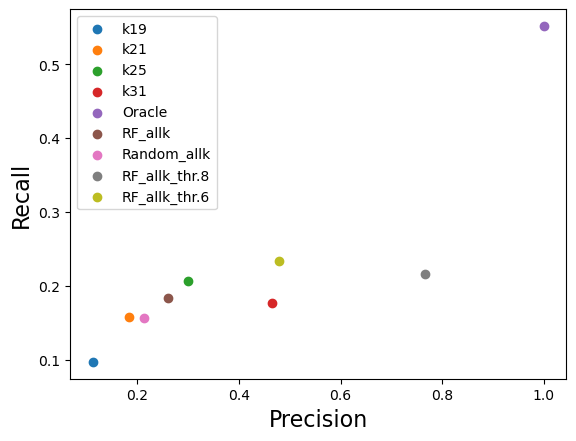

In [525]:
lgends=[]
prs=[]
recs=[]
for lgend, pr_rec in stats.items():
    lgends.append(lgend)
    prs.append(pr_rec[0])
    recs.append(pr_rec[1])

del prs[-1]
del recs[-1]
del lgends[-1]
#lgends[-1]='RF_allk_thr.4'

lgends[0]='k19'
lgends[1]='k21'
lgends[2]='k25'
lgends[3]='k31'
lgends[4]='Oracle'
prs.append(0.7651)
recs.append(0.2167)
lgends.append('RF_allk_thr.8')

prs.append(0.4779)
recs.append(0.234 )
lgends.append('RF_allk_thr.6')


for i in range(len(prs)):
    plt.scatter(prs[i],recs[i])
plt.legend(lgends)
plt.xlabel('Precision',fontsize=16)
plt.ylabel('Recall',fontsize=16)
plt.savefig('out.png',dpi=300)

In [518]:
prs[-1],recs[-1]# [/(prs[i]+recs[i]

(0.7651, 0.2167)

In [526]:
F1s= [2*prs[i]*recs[i]/(prs[i]+recs[i]) for i in range(len(prs))]
F1s

[0.10417320363978663,
 0.16993464052287582,
 0.2445793581960104,
 0.2562371037328831,
 0.7111317685335812,
 0.21548994437312796,
 0.18080640437371864,
 0.3377412303931554,
 0.3141694058154235]

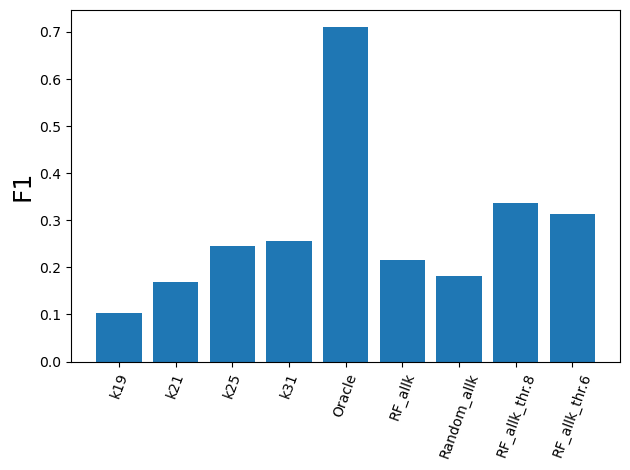

In [527]:
plt.bar(lgends,F1s)
#plt.xlabel('Precision',fontsize=16)
plt.ylabel('F1',fontsize=18)
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('out2.png',dpi=300)

In [ ]:
cnt_true=0
true_tax_all_test={}
for index, row in merged2a.iterrows():
    read_id = row['read_name']
    #if read_id in read_names_:
    tax_true = row['taxon']
    if predicted_k[read_id]==0:
        tax_est=0
    else:
        tax_est = row['taxon_tool_k'+str(predicted_k[read_id])]

    if tax_est==tax_true:
        cnt_true+1
    true_tax_all_test[read_id]=tax_est
len(true_tax_all_test),read_id, cnt_true, cnt_true/len(merged2a)

In [ ]:
tax_est, tax_true

In [ ]:
Counter(y_test2)

In [ ]:
# #read_names_=read_names#[:1000]
# y_test2=[]
# for read_idx, read_id in enumerate(read_names_test_):
#     true_tax_idx=0
#     if read_id in true_tax_all_test:
#         true_tax=true_tax_all_test[read_id]
#         if true_tax in dic_tax_idx:
#             true_tax_idx=int(dic_tax_idx[true_tax])
#     y_test2.append(true_tax_idx)

# print(sum([1 for i in y_test2 if i!=0]))
# y_test2=np.array(y_test2)

# print('y',len(y_test2))

In [ ]:
sum([1 for i in range(len(y_pred)) if y_pred[i]==y_test2[i]])/len(y_pred)

In [ ]:
# dic_idx_tax = {v: k for k, v in dic_tax_idx.items()}
# predicted_tax= {}
# for read_idx, read_id in enumerate(read_names_test):
#     tax= dic_idx_tax[y_pred[read_idx]]
#     predicted_tax[read_id]=tax
# len(predicted_tax)    

In [ ]:

tax_level='species'
tax_l_list=[]
tax_true_test={}
tax_list=[]
all_tax_set=set(all_tax)
read_name_species_lower = set()
for index, row in merged.iterrows():
    read_id = row['read_name']
    tax_true = row['taxon']
    tax_true_level= find_tax_level(info,tree_df,parents, tax_true, tax_level)
    if tax_true_level!=1 and tax_true_level in all_tax_set:
        read_name_species_lower.add(read_id)
        tax_l_list.append(tax_true_level)
        tax_list.append(tax_true)
        tax_true_test[read_id]=tax_true
print(len(read_name_species_lower), len(merged))


In [ ]:


merged1a=merged.copy()
merged1a= merged1a[merged1a['read_name'].isin(read_name_species_lower)]
merged1a.reset_index(drop=True, inplace=True)

len(merged1a)


notfndd=0
merged2=merged1a.copy()
read_names_=read_names_test #list(predicted_tax.keys())
print(len(read_names_))
merged2a= merged2[merged2['read_name'].isin(read_names_)]
merged2a.reset_index(drop=True, inplace=True)

new_estimates=[]
for index, row in merged2a.iterrows():
    read=row['read_name']
    if read in predicted_tax:
        new_estimates.append(predicted_tax[read])
    else:
        new_estimates.append(0)
        notfndd+=1
print(notfndd)
case1= "taxon_randomforst" #best/second
merged2a[case1]=new_estimates
merged2a



#case1='taxon_best/second'
#case_dic_all[case]
cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
#cases_dic_ = case_dic_all[case]
FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
F1=0
if (precision+recall):
    
    F1= 2* precision* recall/(precision+recall)
print('F1', "precision",'recal','TP','FP','VP')
print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))



case1='taxon_tool_k31'
cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
#cases_dic_ = case_dic_all[case]
FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
F1=0
if (precision+recall):
    
    F1= 2* precision* recall/(precision+recall)
print('F1', "precision",'recal','TP','FP','VP')
print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))


In [ ]:
from collections import Counter
Counter(new_estimates)

In [ ]:
# from collections import Counter
# Counter(y_pred)
sum([1 for i in range(len(y_test)) if y_test[i]==y_pred[i]])/len(y_test)

In [ ]:
len(new_estimates)

In [ ]:
truth_file="/vast/blangme2/smajidi5/metagenomics/changek/kraken1/classification/cami_soil/long_0_reads_mapping.csv"

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False) # xticklabels=iris.target_names, yticklabels=iris.target_names

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
feature_importances = classifier.feature_importances_

plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()


In [ ]:
# columnid= (case_k-1)*len(all_tax) + tax_idx

 # Get which K is good

In [ ]:
merged2a

In [ ]:
merged2=merged1a.copy()
read_names_=list(predicted_tax.keys())
print(len(read_names_))
merged2a= merged2[merged2['read_name'].isin(read_names_)]
merged2a.reset_index(drop=True, inplace=True)


new_estimates=[]
for index, row in merged2a.iterrows():
    read=row['read_name']
    new_estimates.append(predicted_tax[read])

case1= "taxon_" #best/second
merged2a[case1]=new_estimates


#case1='taxon_best/second'
#case_dic_all[case]
cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
#cases_dic_ = case_dic_all[case]
FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
F1=0
if (precision+recall):
    
    F1= 2* precision* recall/(precision+recall)
print('F1', "precision",'recal','TP','FP','VP')
print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))


In [ ]:
true_k={}

for read_idx, read_id in enumerate(read_names):
    true_k[read_id]=set()
    for case_k, case in  enumerate(cases): # reversed(
        k = int(case[1:3])
        if read_id in case_dic_all[case]['TP']:
            true_k[read_id].add(k)
           
print(len(true_k),len(true_k[read_id]))


In [ ]:
len(merged2a)

In [ ]:
case1='taxon_tool_k31'
#case_dic_all[case]
cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
F1= 2* precision* recall/(precision+recall)
print(case1,round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))


In [ ]:


# oracale 
new_estimates=[]
for index, row in merged2a.iterrows():
    read=row['read_name']
    if read in true_k and true_k[read]: # selected_k
        col='taxon_tool_k'+str(sorted(true_k[read])[-1]) # selected_k
        new_estimate =  row[col]
    else:
        new_estimate=0
    new_estimates.append(new_estimate)
case1= "taxon_orac" #best/second
merged2a[case1]=new_estimates

# merged2a= merged2[merged2['read_name'].isin(read_names_)]
# len(merged2a)

#case1='taxon_best/second'
#case_dic_all[case]
cases_dic_=def_cal(merged2a,info,tree_df,parents,'species',case1,tax_index) #+case
#cases_dic_ = case_dic_all[case]
FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
F1=0
if (precision+recall):
    F1= 2* precision* recall/(precision+recall)
#print('F1', "precision",'recal','TP','FP','VP')
print('oracle',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))


In [ ]:
a

In [ ]:
Counter(y_train)

In [ ]:
X_train

In [ ]:
! which python

# NN

In [ ]:
# import mkl
# mkl.set_num_threads(32)

In [124]:
from sklearn.neural_network import  MLPRegressor

In [125]:
from sklearn.preprocessing import normalize
X_train = normalize(X_train, axis=1, norm='l1') #  1:  independently normalize each sample (row),  0: normalize each feature (column)
np.mean(X_train[:,10]),np.mean(X_train[1])

(np.float64(0.0), np.float64(0.041666666666666664))

In [209]:
# classifier = RandomForestClassifier(n_estimators=1000, random_state=12)
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)


# MLPClassifier MLPRegressor

NN = MLPRegressor(solver='adam'  , alpha=1e-5, hidden_layer_sizes=(100,50,50,10),
                             activation='logistic', random_state=14) # , max_iter=1000 35, 20,10 {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, 
#solver='adam' slower than lbfgs 

NN.fit(X_train, y_train)

MLPRegressor(activation='logistic', alpha=1e-05,
             hidden_layer_sizes=(100, 50, 50, 10), random_state=14)

In [210]:

y_pred_train = NN.predict(X_train)

In [211]:
y_pred_train_binary=np.round(y_pred_train) # round(0.55)=1
print(sum([1 for i in range(len(y_pred_train_binary)) if y_pred_train_binary[i]==y_train[i]])/len(y_pred_train_binary)) # sklearn.metrics.confusion_matrix(y_train, y_traing_pred)

0.8966702743999491


In [212]:
y_pred_test = NN.predict(X_test)

In [213]:
y_pred_test_binary=np.round(y_pred_test) # round(0.55)=1
print(sum([1 for i in range(len(y_pred_test_binary)) if y_pred_test_binary[i]==y_test[i]])/len(y_pred_test_binary)) # sklearn.metrics.confusion_matrix(y_train, y_traing_pred)


0.5077667430608607


In [214]:
Counter(y_test), Counter(y_pred_test_binary)

(Counter({np.int64(1): 2806, np.int64(0): 1121}),
 Counter({np.float64(0.0): 2950, np.float64(1.0): 977}))

In [130]:
# sum([1 for i in range(len(y_pred_train)) if y_pred_train[i]==y_train[i]])/len(y_pred_train)
plt.plot(NN.loss_curve_)


0.0

In [ ]:
# Counter(y_train),Counter(y_pred_train)

In [ ]:

# y_pred_test = classifierNN.predict(X_test)
# sum([1 for i in range(len(y_pred_test)) if y_pred_test[i]==y_test[i]])/len(y_pred_test)


In [ ]:
best_k_dic={}
for ii in range(len(indices_train)):
    read_idxx=indices_train[ii]
    best_k= cases[np.argmax(y_pred_train[ii])]
    best_k_dic[read_names_[read_idxx]]=best_k
read_names_train = [read_names_[i] for i in indices_train]


In [ ]:

# merged2b=merged2a.copy()
# merged2b= merged2a[merged2a['read_name'].isin(read_names_train)]
# merged2b.reset_index(drop=True, inplace=True)


cntr=0
alternative_best_k='k25'
new_estimates=[]
new_estimates_random=[]
for index, row in merged2b.iterrows():
    read=row['read_name']    
    if read in best_k_dic: 
        cntr+=1
        new_estimate =  row['taxon_tool_'+best_k_dic[read]]
    else:
        new_estimate=row['taxon_tool_'+alternative_best_k]
    new_estimates.append(new_estimate)
    
case1= 'NN_allk_tog2_relu'
merged2b[case1]=new_estimates

#print(here)
merged2b.head(2)
print(cntr)

#for case1 in ['RF_allk_tog2']:
for case1 in ['taxon_tool_k'+str(k) for k in  [19,21,25,31]]+["oracle_____","RF_allk", "Random_allk" ,'RF_allk_tog2','NN_allk_tog2', 'NN_allk_tog2_relu']:
    
    cases_dic_=def_cal(merged2b,info,tree_df,parents,'species',case1,tax_index) #+case
    FP=len(cases_dic_['FP-level-index'])+len(cases_dic_['FP-higher-index'])+len(cases_dic_['FP-level-notindex'])+len(cases_dic_['FP-higher-notindex'])
    recall=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + len(cases_dic_['VP']) + len(cases_dic_['FN']) +FP )
    precision=len(cases_dic_['TP'])/(len(cases_dic_['TP']) + FP)
    F1= 2* precision* recall/(precision+recall)
    print(case1,'\t',round(F1,4), round(precision,4),round(recall,4),len(cases_dic_['TP']),FP,len(cases_dic_['VP']))
    # merged[merged['read_name']=="NZ_PNYD02000026.1__1_299"]
    

In [ ]:
Counter(y_pred_test)

In [ ]:
#len(X_train[0]),num_paths,max(y_train)
# for i in range(3):
#     print(i, np.argmax(X_train[0][13862*(i-1):13862*i-1]))
# y_train[0]

In [ ]:
# y_pred = classifier2.predict(X_test_cam)

In [ ]:
# Counter(y_pred)

In [ ]:
 # hidden_layer_sizes=(15,5), 0.75380101,  0.7464
hidden_layer_sizes=(50,50) 0.753801, 0.7464
hidden_layer_sizes=(50, 50, 50)  0.753 0.7512


In [ ]:
# classifier = RandomForestClassifier(n_estimators=1000, random_state=12)
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)

classifierNN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 5), random_state=14)

classifierNN.fit(X_train, y_train)


In [ ]:

y_pred_train = classifierNN.predict(X_train)

In [ ]:
sum([1 for i in range(len(y_pred_train)) if y_pred_train[i]==y_train[i]])/len(y_pred_train)

In [ ]:

y_pred_test = classifierNN.predict(X_test)

In [ ]:
sum([1 for i in range(len(y_pred_test)) if y_pred_test[i]==y_test[i]])/len(y_pred_test)


In [ ]:
# from collections import Counter
# Counter(y_pred)
dic_idx_tax = {v: k for k, v in dic_tax_idx.items()}

predicted_tax= {}
for idx_idx, idx_value in enumerate(indices_test):
    read_id = read_names[idx_value]
    tax= dic_idx_tax[y_pred[idx_idx]]
    predicted_tax[read_id]=tax
len(predicted_tax)    

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


In [ ]:
classifierGB = HistGradientBoostingClassifier()
#GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
classifierGB.fit(X_train, y_train)

In [ ]:

y_pred = classifierGB.predict(X_test)
sum([1 for i in range(len(y_test)) if y_test[i]==y_pred[i]])/len(y_test)

# Xgbost

In [ ]:
import xgboost
# display version
print(xgboost.__version__)
from xgboost import  XGBRFClassifier

In [ ]:
y_train[0]=6
y_train[1]=9

In [ ]:
model_xgboost = XGBRFClassifier(n_estimators=100, subsample=0.9, colsample_bynode=0.5, n_jobs=40, seed=0, max_leaves=5000)

In [ ]:
model_xgboost

In [ ]:
model_xgboost.fit(X_train, y_train)

In [ ]:
y_pred_train = model_xgboost.predict(X_train)


In [ ]:
sum([1 for i in range(len(y_pred_train)) if y_pred_train[i]==y_train[i]])/len(y_pred_train)

In [ ]:
Counter(y_train)

In [ ]:
Counter(y_pred_train)

In [ ]:
y_test_cam1 = model_xgboost.predict(X_test_cam)


In [ ]:
y_val_pred = classifier2.predict(X_val)
sum([1 for i in range(len(y_val_pred)) if y_val_pred[i]==y_val[i]])/len(y_val_pred)

In [ ]:

y_pred_test = model.predict(X_test)
#sum([1 for i in range(len(y_pred_test)) if y_pred_test[i]==y_test[i]])/len(y_pred_test)


In [ ]:
sum([1 for i in range(len(y_pred_test)) if y_pred_test[i]==y_test[i]])/len(y_pred_test)

In [ ]:
len(read_names_test_)

In [ ]:
Counter(y_pred_test)

In [ ]:
y_pred_test = model.predict(X_test_cam)
Counter(y_pred_test)

In [ ]:
all_combinations[15]

In [ ]:
y_pred_test = model.predict(X_test_cam)
Counter(y_pred_test)

In [ ]:
max_k[0]

In [ ]:
from scipy import stats

#m = stats.mode(a)


In [ ]:
len(read_names_test_)


In [ ]:
#dic_idx_tax = {v: k for k, v in dic_tax_idx.items()}
predicted_k= {}
for read_idx, read_id in enumerate(read_names_test_):  # read_names_2_test
    k_comb_idx= y_test_cam1[read_idx]
    max_k= max(all_combinations[k_comb_idx])
    #max_k= int(stats.mode(all_combinations[k_comb_idx])[0])
    predicted_k[read_id]=max_k
len(predicted_k)    

In [ ]:
Counter(predicted_k.values())

In [ ]:
tax_level='species'
cnt_true=0
true_tax_all_test={}
for index, row in merged2a.iterrows():
    read_id = row['read_name']
    #if read_id in read_names_:
    tax_true = row['taxon']
    if predicted_k[read_id]==0:
        tax_est=0
    else:
        tax_est = row['taxon_tool_k'+str(predicted_k[read_id])]
    tax_true_sp = find_tax_level(info,tree_df, parents, tax_true, tax_level)
    tax_est_sp = find_tax_level(info,tree_df, parents, tax_est, tax_level)
    if tax_est_sp==tax_true_sp:
        cnt_true+=1
    true_tax_all_test[read_id]=tax_est
len(true_tax_all_test),read_id, cnt_true, cnt_true/len(merged2a)

In [ ]:
merged2a= merged[merged['read_name'].isin(read_names_test_)]
merged2a.reset_index(drop=True, inplace=True)
len(merged2a)

In [ ]:
tax_level='species'
cnt_true=0
true_tax_all_test={}
for index, row in merged2a.iterrows():
    read_id = row['read_name']
    #if read_id in read_names_:
    tax_true = row['taxon']
    if predicted_k[read_id]==0:
        tax_est=0
    else:
        tax_est = row['taxon_tool_k'+str(predicted_k[read_id])]
    tax_true_sp = find_tax_level(info,tree_df, parents, tax_true, tax_level)
    tax_est_sp = find_tax_level(info,tree_df, parents, tax_est, tax_level)
    if tax_est_sp==tax_true_sp:
        cnt_true+=1
    true_tax_all_test[read_id]=tax_est
len(true_tax_all_test),read_id, cnt_true, cnt_true/len(merged2a)

In [ ]:
a

In [ ]:
cnt_true=0
for index, row in merged2a.iterrows():
    read_id = row['read_name']
    #if read_id in read_names_:
    tax_true = row['taxon']
    tax_est = row['taxon_tool_k31']
    tax_true_sp = find_tax_level(info,tree_df, parents, tax_true, tax_level)
    tax_est_sp = find_tax_level(info,tree_df, parents, tax_est, tax_level)
    if tax_est_sp==tax_true_sp:
        cnt_true+=1   
print(cnt_true , cnt_true/len(merged2a))
    

In [ ]:
cnt_true=0
for index, row in merged2a.iterrows():
    read_id = row['read_name']
    #if read_id in read_names_:
    tax_true = row['taxon']
    tax_est = row['taxon_tool_k16']
    tax_true_sp = find_tax_level(info,tree_df, parents, tax_true, tax_level)
    tax_est_sp = find_tax_level(info,tree_df, parents, tax_est, tax_level)
    if tax_est_sp==tax_true_sp:
        cnt_true+=1   
print(cnt_true , cnt_true/len(merged2a))
    

# other 

## only  at species level and leaf

## only bacteria

In [ ]:

# print("limit analysis to only bacteria")
# #tax_genome_level_lst=list(tax_genome_level)
# #tax2root_all=[]
# tax2root_all_dic = {}
# for tax in tax_genome_level: #list(tax_index_all_level):   
#     tax2root= find_tax2root(info,parents, tax)
#     if tax2root==-1:
#         print("tax",tax)
#     elif 2 in tax2root: # selecting only bacteria
#         #tax2root_all.append(tax2root) # # [655353, 655352, 655351, 356, 28211, 1224, 3379134, 2, 131567, 1]
#         tax2root_all_dic[tax]=tax2root
        
# print("number of paths for genomes in bacteria ", len(tax2root_all_dic), "out of total  ", len(tax_genome_level))



# print("keep index for each tax at level (labels)") 

# tax_genome_level_bact_lst=list(tax2root_all_dic.keys())
# dic_tax_idx={}
# for tax_idx, tax in enumerate(tax_genome_level_bact_lst):
#     dic_tax_idx[tax]=tax_idx  
# dic_idx_tax = {v: k for k, v in dic_tax_idx.items()}
# print(len(dic_tax_idx),len(tax_genome_level_bact_lst))


# # all_tax_raw=[]
# # for i in tax2root_all:
# #     all_tax_raw += [int(ii) for ii in i]
# # all_tax = list(set(all_tax_raw))
# # print(" tax all levels ",len(set(all_tax)))
